# Linear Regression- EDVANCER [Project 3]

### Using GradientRegressor and RandomForest

* Reading Data Set

In [1]:
#pip install --user pandas-profiling
#pip install plotly
#pip install cufflinks
#plotly and cufflinks use for iplot

#LIME
#FeatureTools

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import scale
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

#from pandas_profiling import ProfileReport

# Changing working directory.

import os
path=os.getcwd()
new_path=os.chdir('D:\\Rishabh\\Python')

In [36]:
train_data = pd.read_csv(r"D:\Rishabh\Python\P3 Data\counterfeit_train.csv")
test_data  = pd.read_csv(r"D:\Rishabh\Python\P3 Data\counterfeit_test.csv")

#train_data.head()
#test_data.head()

test_data['Counterfeit_Sales'] = np.nan

# In order to make columns arrangement similar for proper concatenation.
test_data = test_data[train_data.columns]

train_data['data'] = 'train'
test_data['data']  =  'test'

zscore_comp = np.abs(stats.zscore(train_data['Counterfeit_Sales']))

threshold=3
drp_idx = np.where(zscore_comp>threshold)[0]

train_data.drop(drp_idx, inplace=True)
#print(np.where(zscore_comp>threshold), len(drp_idx))

all_data = pd.concat([train_data, test_data], axis=0)
#all_data.describe()

* Pre-DEA

In [37]:
# Gives number of missing values and unique values in columns
for col in all_data.columns:
    print("---------"+str(col)+"---------"+str(all_data[col].dtypes))
    print('Number of Unique value: '+str(all_data[col].nunique()))
    print('Number of missing value: '+str(all_data[col].isnull().sum()))

# OR
all_data.isnull().sum()

---------Medicine_ID---------object
Number of Unique value: 1557
Number of missing value: 0
---------Counterfeit_Weight---------float64
Number of Unique value: 415
Number of missing value: 1418
---------DistArea_ID---------object
Number of Unique value: 10
Number of missing value: 0
---------Active_Since---------int64
Number of Unique value: 9
Number of missing value: 0
---------Medicine_MRP---------float64
Number of Unique value: 5940
Number of missing value: 0
---------Medicine_Type---------object
Number of Unique value: 16
Number of missing value: 0
---------SidEffect_Level---------object
Number of Unique value: 2
Number of missing value: 0
---------Availability_rating---------float64
Number of Unique value: 7825
Number of missing value: 0
---------Area_Type---------object
Number of Unique value: 4
Number of missing value: 0
---------Area_City_Type---------object
Number of Unique value: 3
Number of missing value: 0
---------Area_dist_level---------object
Number of Unique value: 4
Nu

Medicine_ID               0
Counterfeit_Weight     1418
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales      1705
data                      0
dtype: int64

In [38]:
##missing values of Counterfeit weight has been substituted with the weights of similar medicine type
impute_counter_wt_dict = all_data.groupby(['Medicine_ID'])['Counterfeit_Weight'].mean().to_dict()
for key, values in impute_counter_wt_dict.items():
    all_data.loc[all_data['Medicine_ID']==key, 'Counterfeit_Weight'] = np.round(values)

all_data.drop(all_data[all_data['Counterfeit_Weight'].isna()].index ,  inplace=True)

Even after removing some of outliers the data is still skewed, will handle this with Robust Scaler as this uses std deviation for scaling data points which gives better results when the feature is having some outliers.

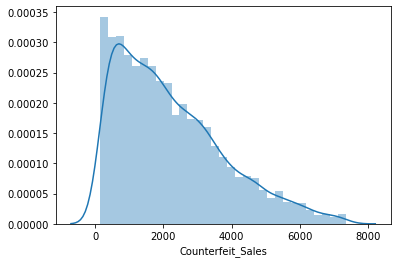

In [39]:
sns.distplot(train_data['Counterfeit_Sales'])

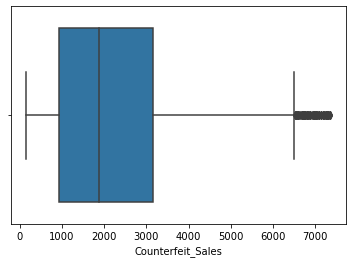

In [40]:
sns.boxplot(x=train_data['Counterfeit_Sales'])

Bivariate analysis of Medicine MRp ,which shows some linear relation with target variable

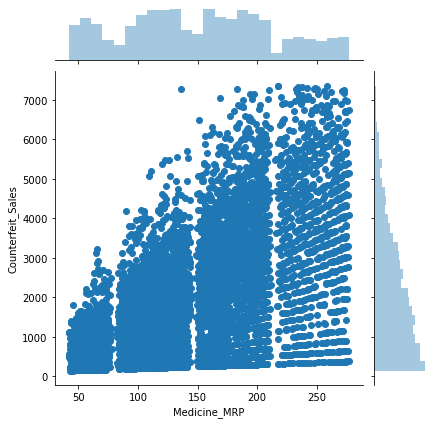

In [41]:
sns.jointplot(x='Medicine_MRP', y='Counterfeit_Sales', data=all_data)

Here we will discretize data of continuous variables, basically splitting cont data into number of bins

In [42]:
##Discretizing numerical data
from sklearn.preprocessing import KBinsDiscretizer

availability_disctriz = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
all_data['Availability_rating_bins'] = availability_disctriz.fit_transform(all_data['Availability_rating'].values.reshape(-1,1)).astype(int)

cols_to_disc      = ['Counterfeit_Weight','Medicine_MRP']
cols_to_disc_bins = ['Counterfeit_Weight_bins','Medicine_MRP_bins']
disctriz = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

all_data[cols_to_disc_bins] = all_data[cols_to_disc]
all_data[cols_to_disc_bins] = disctriz.fit_transform(all_data[cols_to_disc]).astype(int)

#all_data.drop(cols_to_disc ,axis=1 ,inplace=True)
#del all_data['Availability_rating']

Finding Correlation

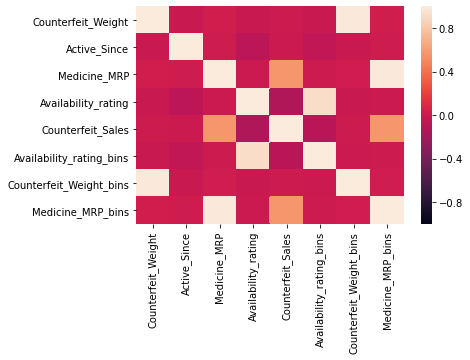

In [43]:
sns.heatmap(all_data.corr(), vmin=-1, vmax=1)

Below function just evaluates the results with diffrent kind of scaling method and normalizer
Standard scaler, Robust scaler and MinMax scaler

In [44]:
def results_of_diff_scaling(df):
    itr=1
    cols_to_std        = ['Counterfeit_Weight','Medicine_MRP', 'Active_Since','Availability_rating','Availability_rating_bins','Counterfeit_Weight_bins','Medicine_MRP_bins']
    target_scaling     = ['Counterfeit_Sales']
    
    '''
    Produces result with std scaler, normalizer, robust scaler
    itr==1 --> std scaler
    itr==2 --> MinMaxScaler
    itr==3 --> RobustScaler
    '''
    while (True):
        all_data_scale=all_data.copy()
        trainData = all_data_scale[all_data_scale['data'] =='train'].copy()
        testData  = all_data_scale[all_data_scale['data'] =='test'].copy()
        
        if itr==1:
            print("\nStandard Scaling Result...\n")            
            stdScale   = StandardScaler().fit(trainData[cols_to_std])
            trgt_scale = StandardScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['data'] =='train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

            x_test  = all_data_scale[all_data_scale['data'] =='test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            xgb_rs_best.fit(train_d, train_dd)
            
            rf=RandomForestRegressor(n_estimators=800,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)
            
            predicted_val = xgb_rs_best.predict(test_d)
            predicted_val_rf = rf.predict(test_d)
            
            predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            #predicted_val    = np.exp(predicted_val)
            #predicted_val_rf = np.exp(predicted_val_rf)
            #test_dd          = np.exp(test_dd)

            MAE = mean_absolute_error(test_dd, predicted_val)
            #Calculating Score
            Score = 1-(MAE/1660)
            r2score = r2_score(test_dd,predicted_val)
            
            print("\nGD : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score , MAE, r2score))
            
            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            #Calculating Score
            Score_rf = 1-(MAE_rf/1660)
            
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            
            print("\nRF : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
            
        if itr==2:
            print("\nNormalizing Result...\n")            
            stdScale   = MinMaxScaler().fit(trainData[cols_to_std])
            trgt_scale = MinMaxScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['data'] =='train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

            x_test  = all_data_scale[all_data_scale['data'] =='test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            xgb_rs_best.fit(train_d, train_dd)
            predicted_val = xgb_rs_best.predict(test_d)
            
            predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))
            test_dd       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            #predicted_val = np.exp(predicted_val)
            #test_dd       = np.exp(test_dd)

            MAE = mean_absolute_error(test_dd, predicted_val)
            #Calculating Score
            Score = 1-(MAE/1660)
            r2score = r2_score(test_dd,predicted_val)
            
            print("\nGD : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score , MAE, r2score))


        if itr==3:
            print("\nRobust Scaling Result...\n")            
            stdScale   = RobustScaler().fit(trainData[cols_to_std])
            trgt_scale = RobustScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['data'] =='train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

            x_test  = all_data_scale[all_data_scale['data'] =='test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            xgb_rs_best.fit(train_d, train_dd)
            predicted_val = xgb_rs_best.predict(test_d)
            
            rf=RandomForestRegressor(n_estimators=600,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)            
            predicted_val_rf = rf.predict(test_d)
            
            predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            #predicted_val = np.exp(predicted_val)
            #test_dd       = np.exp(test_dd)
            
            MAE = mean_absolute_error(test_dd, predicted_val)
            #Calculating Score
            Score = 1-(MAE/1660)
            r2score = r2_score(test_dd,predicted_val)
            
            print("\nGD : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score , MAE, r2score))

            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            #Calculating Score
            Score_rf = 1-(MAE_rf/1660)
            
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            
            print("\nRF : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
        
        if itr > 3:
            break
            
        itr = itr+1

Encoding of categorical data

In [45]:
#GEt dummies
col_to_crt_dummy=['SidEffect_Level', 'Area_Type', 'Area_City_Type', 'Area_dist_level']
for cat_col in col_to_crt_dummy:
    dummy_col = pd.get_dummies(all_data[cat_col], drop_first=True, prefix=cat_col)
    all_data  = pd.concat([all_data , dummy_col], axis=1, ignore_index=False)
    del all_data[cat_col]

#Encoding
#DistArea_ID , Medicine_Type
import category_encoders as ce

all_data['DistArea_ID'] = all_data['DistArea_ID'].replace('Area', '')
be = ce.BinaryEncoder(cols=['DistArea_ID'])
cityCodes = be.fit_transform(all_data['DistArea_ID'] , all_data['Counterfeit_Sales'])
all_data  = pd.concat([all_data, cityCodes] , axis=1)

#del all_data['DistArea_ID_0']
medicine_type_enc = all_data['Medicine_Type'].value_counts().to_dict()
all_data['Medicine_Type'] = all_data['Medicine_Type'].replace(medicine_type_enc)

all_data.drop(['Medicine_ID'], axis=1,inplace=True)
all_data.drop(['DistArea_ID'], axis=1,inplace=True)
#all_data.drop(['Active_Since'],axis=1,inplace=True)
#all_data.drop('Medicine_Type', axis=1, inplace=True)

In [1469]:
results_of_diff_scaling(all_data)


Standard Scaling Result...


GD : Score : 0.5507865500382281 and MeanAbsError 745.6943269365415 and R2 Score 0.5529904566910109

RF : Score : 0.5560236781614771 and MeanAbsError 737.000694251948 and R2 Score 0.5605896093551084

Normalizing Result...


GD : Score : 0.5668059449362772 and MeanAbsError 719.1021314057798 and R2 Score 0.5873603872045218

Robust Scaling Result...


GD : Score : 0.5583471122740964 and MeanAbsError 733.143793625 and R2 Score 0.5906856901970283

RF : Score : 0.5627678190010872 and MeanAbsError 725.8054204581953 and R2 Score 0.5948629155381124


In [46]:
##Standerdizing data with robust scaler
##Robust scaler deals with the deviations in data

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

cols_to_std = cols_to_std        = ['Counterfeit_Weight','Medicine_MRP', 'Active_Since', 'Availability_rating','Availability_rating_bins','Counterfeit_Weight_bins','Medicine_MRP_bins']
target_scaling                   = ['Counterfeit_Sales']

trainData = all_data[all_data['data'] =='train'].copy()
testData  = all_data[all_data['data'] =='test'].copy()

stdScale   = RobustScaler().fit(trainData[cols_to_std])
trgt_scale = RobustScaler().fit(trainData[target_scaling])

trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
testData[cols_to_std]     = stdScale.transform(testData[cols_to_std])

trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])

all_data = pd.concat([trainData, testData], axis=0)

In [47]:
#Two variables dropped after feature engg.
all_data.drop(['Counterfeit_Weight', 'Availability_rating_bins'] ,axis=1, inplace=True)

x_train = all_data[all_data['data'] =='train'].copy()

y_train = x_train['Counterfeit_Sales']
x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

x_test = all_data[all_data['data'] =='test'].copy()
x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)

test_dd_invtrf  = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
train_dd_invtrf = trgt_scale.inverse_transform(np.array(train_dd).reshape(-1,1))

In [48]:
all_data.shape

(8452, 22)

In [50]:
##XGboost
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_r = xg.XGBRegressor(eval_metric = 'mae') 

param_test_xgb = {
 'max_depth'       :[4,5,6],
 'min_child_weight':[0,1,2],
 'gamma'           :[0, 0.1,0.2],
 'reg_alpha'       :[0.1, 0.01, 0.05],
 'reg_lambda'      :[0.1, 0.01, 0.05],
 'colsample_bytree'  :[0.7],
 'learning_rate'     : [.03, 0.02, 0.01],
 'n_estimators'   : [700,850,1000]
}

xgb_rs = RandomizedSearchCV(xgb_r , param_distributions=param_test_xgb, cv=5, n_iter=10, scoring='neg_mean_absolute_error')

xgb_rs.fit(train_d, train_dd, early_stopping_rounds=7, eval_set =[(train_d, train_dd), (test_d, test_dd)]) 
  
pred     = xgb_rs.predict(train_d) 
pred     = trgt_scale.inverse_transform(np.array(pred).reshape(-1,1))

# RMSE Computation 
rmse = np.sqrt(MSE(train_dd_invtrf, pred)) 
print("Train RMSE : % f" %(rmse)) 

pred_test = xgb_rs.predict(test_d) 
pred_test = trgt_scale.inverse_transform(np.array(pred_test).reshape(-1,1))

rmse = np.sqrt(MSE(test_dd_invtrf, pred_test)) 
print("Test RMSE : % f" %(rmse)) 

[0]	validation_0-mae:0.66159	validation_1-mae:0.66357
[1]	validation_0-mae:0.64856	validation_1-mae:0.64997
[2]	validation_0-mae:0.63584	validation_1-mae:0.63667
[3]	validation_0-mae:0.62372	validation_1-mae:0.62399
[4]	validation_0-mae:0.61238	validation_1-mae:0.61216
[5]	validation_0-mae:0.60601	validation_1-mae:0.60548
[6]	validation_0-mae:0.59509	validation_1-mae:0.59391
[7]	validation_0-mae:0.58457	validation_1-mae:0.58275
[8]	validation_0-mae:0.57422	validation_1-mae:0.57204
[9]	validation_0-mae:0.56443	validation_1-mae:0.56184
[10]	validation_0-mae:0.55481	validation_1-mae:0.55196
[11]	validation_0-mae:0.54582	validation_1-mae:0.54293
[12]	validation_0-mae:0.53699	validation_1-mae:0.53381
[13]	validation_0-mae:0.52838	validation_1-mae:0.52500
[14]	validation_0-mae:0.52009	validation_1-mae:0.51650
[15]	validation_0-mae:0.51211	validation_1-mae:0.50833
[16]	validation_0-mae:0.50432	validation_1-mae:0.50053
[17]	validation_0-mae:0.49687	validation_1-mae:0.49294
[18]	validation_0-ma

[8]	validation_0-mae:0.57406	validation_1-mae:0.57154
[9]	validation_0-mae:0.56420	validation_1-mae:0.56122
[10]	validation_0-mae:0.55456	validation_1-mae:0.55123
[11]	validation_0-mae:0.54557	validation_1-mae:0.54212
[12]	validation_0-mae:0.53675	validation_1-mae:0.53297
[13]	validation_0-mae:0.52817	validation_1-mae:0.52417
[14]	validation_0-mae:0.51989	validation_1-mae:0.51562
[15]	validation_0-mae:0.51182	validation_1-mae:0.50738
[16]	validation_0-mae:0.50406	validation_1-mae:0.49945
[17]	validation_0-mae:0.49668	validation_1-mae:0.49199
[18]	validation_0-mae:0.48930	validation_1-mae:0.48475
[19]	validation_0-mae:0.48281	validation_1-mae:0.47832
[20]	validation_0-mae:0.47594	validation_1-mae:0.47164
[21]	validation_0-mae:0.46999	validation_1-mae:0.46570
[22]	validation_0-mae:0.46366	validation_1-mae:0.45941
[23]	validation_0-mae:0.45760	validation_1-mae:0.45348
[24]	validation_0-mae:0.45172	validation_1-mae:0.44782
[25]	validation_0-mae:0.44654	validation_1-mae:0.44280
[26]	validat

[16]	validation_0-mae:0.50481	validation_1-mae:0.50074
[17]	validation_0-mae:0.49749	validation_1-mae:0.49313
[18]	validation_0-mae:0.49018	validation_1-mae:0.48587
[19]	validation_0-mae:0.48367	validation_1-mae:0.47928
[20]	validation_0-mae:0.47687	validation_1-mae:0.47261
[21]	validation_0-mae:0.47051	validation_1-mae:0.46644
[22]	validation_0-mae:0.46432	validation_1-mae:0.46021
[23]	validation_0-mae:0.45836	validation_1-mae:0.45438
[24]	validation_0-mae:0.45241	validation_1-mae:0.44859
[25]	validation_0-mae:0.44734	validation_1-mae:0.44375
[26]	validation_0-mae:0.44204	validation_1-mae:0.43853
[27]	validation_0-mae:0.43679	validation_1-mae:0.43341
[28]	validation_0-mae:0.43223	validation_1-mae:0.42915
[29]	validation_0-mae:0.42736	validation_1-mae:0.42445
[30]	validation_0-mae:0.42263	validation_1-mae:0.41983
[31]	validation_0-mae:0.41801	validation_1-mae:0.41544
[32]	validation_0-mae:0.41362	validation_1-mae:0.41124
[33]	validation_0-mae:0.40938	validation_1-mae:0.40720
[34]	valid

[25]	validation_0-mae:0.44688	validation_1-mae:0.44414
[26]	validation_0-mae:0.44157	validation_1-mae:0.43897
[27]	validation_0-mae:0.43636	validation_1-mae:0.43384
[28]	validation_0-mae:0.43141	validation_1-mae:0.42914
[29]	validation_0-mae:0.42653	validation_1-mae:0.42423
[30]	validation_0-mae:0.42181	validation_1-mae:0.41952
[31]	validation_0-mae:0.41719	validation_1-mae:0.41512
[32]	validation_0-mae:0.41281	validation_1-mae:0.41082
[33]	validation_0-mae:0.40865	validation_1-mae:0.40677
[34]	validation_0-mae:0.40459	validation_1-mae:0.40304
[35]	validation_0-mae:0.40073	validation_1-mae:0.39943
[36]	validation_0-mae:0.39696	validation_1-mae:0.39572
[37]	validation_0-mae:0.39331	validation_1-mae:0.39215
[38]	validation_0-mae:0.38980	validation_1-mae:0.38886
[39]	validation_0-mae:0.38643	validation_1-mae:0.38570
[40]	validation_0-mae:0.38318	validation_1-mae:0.38258
[41]	validation_0-mae:0.38006	validation_1-mae:0.37949
[42]	validation_0-mae:0.37703	validation_1-mae:0.37662
[43]	valid

[21]	validation_0-mae:0.46970	validation_1-mae:0.46512
[22]	validation_0-mae:0.46346	validation_1-mae:0.45894
[23]	validation_0-mae:0.45744	validation_1-mae:0.45297
[24]	validation_0-mae:0.45154	validation_1-mae:0.44709
[25]	validation_0-mae:0.44650	validation_1-mae:0.44215
[26]	validation_0-mae:0.44113	validation_1-mae:0.43666
[27]	validation_0-mae:0.43585	validation_1-mae:0.43140
[28]	validation_0-mae:0.43117	validation_1-mae:0.42686
[29]	validation_0-mae:0.42632	validation_1-mae:0.42216
[30]	validation_0-mae:0.42153	validation_1-mae:0.41752
[31]	validation_0-mae:0.41694	validation_1-mae:0.41307
[32]	validation_0-mae:0.41250	validation_1-mae:0.40871
[33]	validation_0-mae:0.40828	validation_1-mae:0.40458
[34]	validation_0-mae:0.40423	validation_1-mae:0.40058
[35]	validation_0-mae:0.40034	validation_1-mae:0.39677
[36]	validation_0-mae:0.39651	validation_1-mae:0.39298
[37]	validation_0-mae:0.39280	validation_1-mae:0.38943
[38]	validation_0-mae:0.38915	validation_1-mae:0.38596
[39]	valid

[15]	validation_0-mae:0.61273	validation_1-mae:0.61195
[16]	validation_0-mae:0.60899	validation_1-mae:0.60799
[17]	validation_0-mae:0.60538	validation_1-mae:0.60419
[18]	validation_0-mae:0.60173	validation_1-mae:0.60032
[19]	validation_0-mae:0.59848	validation_1-mae:0.59685
[20]	validation_0-mae:0.59492	validation_1-mae:0.59307
[21]	validation_0-mae:0.59169	validation_1-mae:0.58978
[22]	validation_0-mae:0.58823	validation_1-mae:0.58609
[23]	validation_0-mae:0.58484	validation_1-mae:0.58252
[24]	validation_0-mae:0.58144	validation_1-mae:0.57893
[25]	validation_0-mae:0.57850	validation_1-mae:0.57585
[26]	validation_0-mae:0.57534	validation_1-mae:0.57254
[27]	validation_0-mae:0.57208	validation_1-mae:0.56905
[28]	validation_0-mae:0.56918	validation_1-mae:0.56596
[29]	validation_0-mae:0.56613	validation_1-mae:0.56274
[30]	validation_0-mae:0.56298	validation_1-mae:0.55939
[31]	validation_0-mae:0.55984	validation_1-mae:0.55609
[32]	validation_0-mae:0.55676	validation_1-mae:0.55285
[33]	valid

[163]	validation_0-mae:0.35961	validation_1-mae:0.35285
[164]	validation_0-mae:0.35896	validation_1-mae:0.35217
[165]	validation_0-mae:0.35831	validation_1-mae:0.35153
[166]	validation_0-mae:0.35775	validation_1-mae:0.35109
[167]	validation_0-mae:0.35712	validation_1-mae:0.35045
[168]	validation_0-mae:0.35649	validation_1-mae:0.34986
[169]	validation_0-mae:0.35587	validation_1-mae:0.34925
[170]	validation_0-mae:0.35529	validation_1-mae:0.34876
[171]	validation_0-mae:0.35469	validation_1-mae:0.34815
[172]	validation_0-mae:0.35411	validation_1-mae:0.34762
[173]	validation_0-mae:0.35354	validation_1-mae:0.34701
[174]	validation_0-mae:0.35296	validation_1-mae:0.34644
[175]	validation_0-mae:0.35240	validation_1-mae:0.34583
[176]	validation_0-mae:0.35183	validation_1-mae:0.34528
[177]	validation_0-mae:0.35130	validation_1-mae:0.34469
[178]	validation_0-mae:0.35094	validation_1-mae:0.34432
[179]	validation_0-mae:0.35042	validation_1-mae:0.34375
[180]	validation_0-mae:0.34988	validation_1-mae:

[310]	validation_0-mae:0.31629	validation_1-mae:0.31376
[311]	validation_0-mae:0.31617	validation_1-mae:0.31366
[312]	validation_0-mae:0.31603	validation_1-mae:0.31356
[313]	validation_0-mae:0.31591	validation_1-mae:0.31351
[314]	validation_0-mae:0.31580	validation_1-mae:0.31349
[315]	validation_0-mae:0.31569	validation_1-mae:0.31346
[316]	validation_0-mae:0.31556	validation_1-mae:0.31337
[317]	validation_0-mae:0.31544	validation_1-mae:0.31328
[318]	validation_0-mae:0.31532	validation_1-mae:0.31323
[319]	validation_0-mae:0.31520	validation_1-mae:0.31314
[320]	validation_0-mae:0.31508	validation_1-mae:0.31308
[321]	validation_0-mae:0.31496	validation_1-mae:0.31298
[322]	validation_0-mae:0.31484	validation_1-mae:0.31289
[323]	validation_0-mae:0.31473	validation_1-mae:0.31281
[324]	validation_0-mae:0.31462	validation_1-mae:0.31279
[325]	validation_0-mae:0.31451	validation_1-mae:0.31272
[326]	validation_0-mae:0.31440	validation_1-mae:0.31267
[327]	validation_0-mae:0.31428	validation_1-mae:

[2]	validation_0-mae:0.66206	validation_1-mae:0.66388
[3]	validation_0-mae:0.65776	validation_1-mae:0.65930
[4]	validation_0-mae:0.65399	validation_1-mae:0.65534
[5]	validation_0-mae:0.65163	validation_1-mae:0.65283
[6]	validation_0-mae:0.64748	validation_1-mae:0.64840
[7]	validation_0-mae:0.64338	validation_1-mae:0.64402
[8]	validation_0-mae:0.63929	validation_1-mae:0.63968
[9]	validation_0-mae:0.63541	validation_1-mae:0.63557
[10]	validation_0-mae:0.63141	validation_1-mae:0.63133
[11]	validation_0-mae:0.62781	validation_1-mae:0.62764
[12]	validation_0-mae:0.62392	validation_1-mae:0.62356
[13]	validation_0-mae:0.62032	validation_1-mae:0.61991
[14]	validation_0-mae:0.61658	validation_1-mae:0.61594
[15]	validation_0-mae:0.61286	validation_1-mae:0.61199
[16]	validation_0-mae:0.60913	validation_1-mae:0.60803
[17]	validation_0-mae:0.60561	validation_1-mae:0.60427
[18]	validation_0-mae:0.60195	validation_1-mae:0.60037
[19]	validation_0-mae:0.59877	validation_1-mae:0.59698
[20]	validation_0-

[151]	validation_0-mae:0.36760	validation_1-mae:0.36103
[152]	validation_0-mae:0.36683	validation_1-mae:0.36030
[153]	validation_0-mae:0.36614	validation_1-mae:0.35969
[154]	validation_0-mae:0.36563	validation_1-mae:0.35918
[155]	validation_0-mae:0.36489	validation_1-mae:0.35845
[156]	validation_0-mae:0.36416	validation_1-mae:0.35773
[157]	validation_0-mae:0.36345	validation_1-mae:0.35707
[158]	validation_0-mae:0.36272	validation_1-mae:0.35636
[159]	validation_0-mae:0.36202	validation_1-mae:0.35567
[160]	validation_0-mae:0.36133	validation_1-mae:0.35505
[161]	validation_0-mae:0.36065	validation_1-mae:0.35438
[162]	validation_0-mae:0.36020	validation_1-mae:0.35390
[163]	validation_0-mae:0.35952	validation_1-mae:0.35327
[164]	validation_0-mae:0.35886	validation_1-mae:0.35263
[165]	validation_0-mae:0.35821	validation_1-mae:0.35198
[166]	validation_0-mae:0.35765	validation_1-mae:0.35147
[167]	validation_0-mae:0.35700	validation_1-mae:0.35088
[168]	validation_0-mae:0.35642	validation_1-mae:

[298]	validation_0-mae:0.31773	validation_1-mae:0.31486
[299]	validation_0-mae:0.31760	validation_1-mae:0.31475
[300]	validation_0-mae:0.31746	validation_1-mae:0.31465
[301]	validation_0-mae:0.31732	validation_1-mae:0.31455
[302]	validation_0-mae:0.31719	validation_1-mae:0.31450
[303]	validation_0-mae:0.31707	validation_1-mae:0.31439
[304]	validation_0-mae:0.31694	validation_1-mae:0.31431
[305]	validation_0-mae:0.31681	validation_1-mae:0.31422
[306]	validation_0-mae:0.31667	validation_1-mae:0.31421
[307]	validation_0-mae:0.31654	validation_1-mae:0.31418
[308]	validation_0-mae:0.31643	validation_1-mae:0.31411
[309]	validation_0-mae:0.31629	validation_1-mae:0.31402
[310]	validation_0-mae:0.31617	validation_1-mae:0.31400
[311]	validation_0-mae:0.31604	validation_1-mae:0.31393
[312]	validation_0-mae:0.31591	validation_1-mae:0.31385
[313]	validation_0-mae:0.31580	validation_1-mae:0.31379
[314]	validation_0-mae:0.31569	validation_1-mae:0.31375
[315]	validation_0-mae:0.31560	validation_1-mae:

[22]	validation_0-mae:0.58852	validation_1-mae:0.58640
[23]	validation_0-mae:0.58516	validation_1-mae:0.58282
[24]	validation_0-mae:0.58177	validation_1-mae:0.57920
[25]	validation_0-mae:0.57883	validation_1-mae:0.57611
[26]	validation_0-mae:0.57561	validation_1-mae:0.57272
[27]	validation_0-mae:0.57236	validation_1-mae:0.56924
[28]	validation_0-mae:0.56951	validation_1-mae:0.56627
[29]	validation_0-mae:0.56646	validation_1-mae:0.56304
[30]	validation_0-mae:0.56332	validation_1-mae:0.55972
[31]	validation_0-mae:0.56020	validation_1-mae:0.55642
[32]	validation_0-mae:0.55713	validation_1-mae:0.55317
[33]	validation_0-mae:0.55413	validation_1-mae:0.55003
[34]	validation_0-mae:0.55125	validation_1-mae:0.54702
[35]	validation_0-mae:0.54878	validation_1-mae:0.54450
[36]	validation_0-mae:0.54585	validation_1-mae:0.54143
[37]	validation_0-mae:0.54296	validation_1-mae:0.53838
[38]	validation_0-mae:0.54008	validation_1-mae:0.53536
[39]	validation_0-mae:0.53738	validation_1-mae:0.53252
[40]	valid

[170]	validation_0-mae:0.35700	validation_1-mae:0.35160
[171]	validation_0-mae:0.35638	validation_1-mae:0.35097
[172]	validation_0-mae:0.35585	validation_1-mae:0.35047
[173]	validation_0-mae:0.35524	validation_1-mae:0.34987
[174]	validation_0-mae:0.35466	validation_1-mae:0.34930
[175]	validation_0-mae:0.35408	validation_1-mae:0.34871
[176]	validation_0-mae:0.35351	validation_1-mae:0.34812
[177]	validation_0-mae:0.35295	validation_1-mae:0.34754
[178]	validation_0-mae:0.35256	validation_1-mae:0.34713
[179]	validation_0-mae:0.35201	validation_1-mae:0.34656
[180]	validation_0-mae:0.35146	validation_1-mae:0.34603
[181]	validation_0-mae:0.35091	validation_1-mae:0.34545
[182]	validation_0-mae:0.35038	validation_1-mae:0.34494
[183]	validation_0-mae:0.34994	validation_1-mae:0.34456
[184]	validation_0-mae:0.34957	validation_1-mae:0.34415
[185]	validation_0-mae:0.34905	validation_1-mae:0.34365
[186]	validation_0-mae:0.34863	validation_1-mae:0.34328
[187]	validation_0-mae:0.34812	validation_1-mae:

[317]	validation_0-mae:0.31640	validation_1-mae:0.31555
[318]	validation_0-mae:0.31631	validation_1-mae:0.31552
[319]	validation_0-mae:0.31618	validation_1-mae:0.31541
[320]	validation_0-mae:0.31606	validation_1-mae:0.31533
[321]	validation_0-mae:0.31594	validation_1-mae:0.31525
[322]	validation_0-mae:0.31581	validation_1-mae:0.31517
[323]	validation_0-mae:0.31570	validation_1-mae:0.31509
[324]	validation_0-mae:0.31562	validation_1-mae:0.31505
[325]	validation_0-mae:0.31550	validation_1-mae:0.31499
[326]	validation_0-mae:0.31538	validation_1-mae:0.31494
[327]	validation_0-mae:0.31525	validation_1-mae:0.31491
[328]	validation_0-mae:0.31514	validation_1-mae:0.31486
[329]	validation_0-mae:0.31501	validation_1-mae:0.31483
[330]	validation_0-mae:0.31491	validation_1-mae:0.31481
[331]	validation_0-mae:0.31479	validation_1-mae:0.31478
[332]	validation_0-mae:0.31471	validation_1-mae:0.31474
[333]	validation_0-mae:0.31459	validation_1-mae:0.31474
[334]	validation_0-mae:0.31450	validation_1-mae:

[47]	validation_0-mae:0.51578	validation_1-mae:0.51060
[48]	validation_0-mae:0.51323	validation_1-mae:0.50795
[49]	validation_0-mae:0.51079	validation_1-mae:0.50538
[50]	validation_0-mae:0.50841	validation_1-mae:0.50291
[51]	validation_0-mae:0.50696	validation_1-mae:0.50136
[52]	validation_0-mae:0.50452	validation_1-mae:0.49881
[53]	validation_0-mae:0.50309	validation_1-mae:0.49732
[54]	validation_0-mae:0.50169	validation_1-mae:0.49584
[55]	validation_0-mae:0.49941	validation_1-mae:0.49353
[56]	validation_0-mae:0.49706	validation_1-mae:0.49105
[57]	validation_0-mae:0.49496	validation_1-mae:0.48893
[58]	validation_0-mae:0.49268	validation_1-mae:0.48657
[59]	validation_0-mae:0.49063	validation_1-mae:0.48453
[60]	validation_0-mae:0.48931	validation_1-mae:0.48313
[61]	validation_0-mae:0.48709	validation_1-mae:0.48087
[62]	validation_0-mae:0.48579	validation_1-mae:0.47954
[63]	validation_0-mae:0.48384	validation_1-mae:0.47770
[64]	validation_0-mae:0.48168	validation_1-mae:0.47550
[65]	valid

[195]	validation_0-mae:0.34361	validation_1-mae:0.33941
[196]	validation_0-mae:0.34329	validation_1-mae:0.33909
[197]	validation_0-mae:0.34288	validation_1-mae:0.33876
[198]	validation_0-mae:0.34245	validation_1-mae:0.33833
[199]	validation_0-mae:0.34204	validation_1-mae:0.33794
[200]	validation_0-mae:0.34166	validation_1-mae:0.33763
[201]	validation_0-mae:0.34123	validation_1-mae:0.33721
[202]	validation_0-mae:0.34081	validation_1-mae:0.33679
[203]	validation_0-mae:0.34038	validation_1-mae:0.33637
[204]	validation_0-mae:0.34003	validation_1-mae:0.33605
[205]	validation_0-mae:0.33973	validation_1-mae:0.33576
[206]	validation_0-mae:0.33933	validation_1-mae:0.33536
[207]	validation_0-mae:0.33893	validation_1-mae:0.33495
[208]	validation_0-mae:0.33855	validation_1-mae:0.33459
[209]	validation_0-mae:0.33815	validation_1-mae:0.33420
[210]	validation_0-mae:0.33778	validation_1-mae:0.33384
[211]	validation_0-mae:0.33742	validation_1-mae:0.33349
[212]	validation_0-mae:0.33705	validation_1-mae:

[342]	validation_0-mae:0.31331	validation_1-mae:0.31520
[343]	validation_0-mae:0.31322	validation_1-mae:0.31518
[344]	validation_0-mae:0.31312	validation_1-mae:0.31516
[345]	validation_0-mae:0.31303	validation_1-mae:0.31516
[346]	validation_0-mae:0.31293	validation_1-mae:0.31512
[347]	validation_0-mae:0.31283	validation_1-mae:0.31506
[348]	validation_0-mae:0.31274	validation_1-mae:0.31505
[349]	validation_0-mae:0.31266	validation_1-mae:0.31499
[350]	validation_0-mae:0.31256	validation_1-mae:0.31495
[351]	validation_0-mae:0.31245	validation_1-mae:0.31488
[352]	validation_0-mae:0.31235	validation_1-mae:0.31483
[353]	validation_0-mae:0.31226	validation_1-mae:0.31479
[354]	validation_0-mae:0.31217	validation_1-mae:0.31468
[355]	validation_0-mae:0.31209	validation_1-mae:0.31463
[356]	validation_0-mae:0.31199	validation_1-mae:0.31455
[357]	validation_0-mae:0.31191	validation_1-mae:0.31450
[358]	validation_0-mae:0.31182	validation_1-mae:0.31446
[359]	validation_0-mae:0.31173	validation_1-mae:

[489]	validation_0-mae:0.30368	validation_1-mae:0.31222
[490]	validation_0-mae:0.30363	validation_1-mae:0.31218
[491]	validation_0-mae:0.30358	validation_1-mae:0.31216
[492]	validation_0-mae:0.30356	validation_1-mae:0.31216
[493]	validation_0-mae:0.30350	validation_1-mae:0.31217
[494]	validation_0-mae:0.30345	validation_1-mae:0.31219
[495]	validation_0-mae:0.30342	validation_1-mae:0.31217
[496]	validation_0-mae:0.30335	validation_1-mae:0.31217
[497]	validation_0-mae:0.30333	validation_1-mae:0.31215
[498]	validation_0-mae:0.30329	validation_1-mae:0.31214
[499]	validation_0-mae:0.30327	validation_1-mae:0.31213
[500]	validation_0-mae:0.30321	validation_1-mae:0.31214
[501]	validation_0-mae:0.30317	validation_1-mae:0.31213
[502]	validation_0-mae:0.30313	validation_1-mae:0.31212
[503]	validation_0-mae:0.30310	validation_1-mae:0.31211
[504]	validation_0-mae:0.30307	validation_1-mae:0.31210
[505]	validation_0-mae:0.30303	validation_1-mae:0.31212
[506]	validation_0-mae:0.30296	validation_1-mae:

[120]	validation_0-mae:0.39509	validation_1-mae:0.38725
[121]	validation_0-mae:0.39396	validation_1-mae:0.38611
[122]	validation_0-mae:0.39287	validation_1-mae:0.38508
[123]	validation_0-mae:0.39190	validation_1-mae:0.38417
[124]	validation_0-mae:0.39080	validation_1-mae:0.38308
[125]	validation_0-mae:0.38974	validation_1-mae:0.38203
[126]	validation_0-mae:0.38870	validation_1-mae:0.38098
[127]	validation_0-mae:0.38764	validation_1-mae:0.37992
[128]	validation_0-mae:0.38659	validation_1-mae:0.37888
[129]	validation_0-mae:0.38555	validation_1-mae:0.37784
[130]	validation_0-mae:0.38454	validation_1-mae:0.37683
[131]	validation_0-mae:0.38357	validation_1-mae:0.37588
[132]	validation_0-mae:0.38295	validation_1-mae:0.37523
[133]	validation_0-mae:0.38197	validation_1-mae:0.37424
[134]	validation_0-mae:0.38102	validation_1-mae:0.37331
[135]	validation_0-mae:0.38006	validation_1-mae:0.37235
[136]	validation_0-mae:0.37912	validation_1-mae:0.37145
[137]	validation_0-mae:0.37818	validation_1-mae:

[267]	validation_0-mae:0.32245	validation_1-mae:0.31636
[268]	validation_0-mae:0.32226	validation_1-mae:0.31618
[269]	validation_0-mae:0.32205	validation_1-mae:0.31603
[270]	validation_0-mae:0.32193	validation_1-mae:0.31594
[271]	validation_0-mae:0.32178	validation_1-mae:0.31580
[272]	validation_0-mae:0.32164	validation_1-mae:0.31574
[273]	validation_0-mae:0.32149	validation_1-mae:0.31564
[274]	validation_0-mae:0.32130	validation_1-mae:0.31549
[275]	validation_0-mae:0.32113	validation_1-mae:0.31532
[276]	validation_0-mae:0.32094	validation_1-mae:0.31518
[277]	validation_0-mae:0.32076	validation_1-mae:0.31506
[278]	validation_0-mae:0.32058	validation_1-mae:0.31493
[279]	validation_0-mae:0.32046	validation_1-mae:0.31484
[280]	validation_0-mae:0.32029	validation_1-mae:0.31469
[281]	validation_0-mae:0.32016	validation_1-mae:0.31456
[282]	validation_0-mae:0.31999	validation_1-mae:0.31444
[283]	validation_0-mae:0.31984	validation_1-mae:0.31432
[284]	validation_0-mae:0.31967	validation_1-mae:

[414]	validation_0-mae:0.30775	validation_1-mae:0.30761
[415]	validation_0-mae:0.30772	validation_1-mae:0.30760
[416]	validation_0-mae:0.30769	validation_1-mae:0.30758
[417]	validation_0-mae:0.30764	validation_1-mae:0.30756
[418]	validation_0-mae:0.30760	validation_1-mae:0.30755
[419]	validation_0-mae:0.30755	validation_1-mae:0.30753
[420]	validation_0-mae:0.30750	validation_1-mae:0.30751
[421]	validation_0-mae:0.30746	validation_1-mae:0.30748
[422]	validation_0-mae:0.30740	validation_1-mae:0.30749
[423]	validation_0-mae:0.30736	validation_1-mae:0.30745
[424]	validation_0-mae:0.30732	validation_1-mae:0.30743
[425]	validation_0-mae:0.30727	validation_1-mae:0.30739
[426]	validation_0-mae:0.30721	validation_1-mae:0.30739
[427]	validation_0-mae:0.30717	validation_1-mae:0.30736
[428]	validation_0-mae:0.30711	validation_1-mae:0.30736
[429]	validation_0-mae:0.30707	validation_1-mae:0.30734
[430]	validation_0-mae:0.30702	validation_1-mae:0.30732
[431]	validation_0-mae:0.30698	validation_1-mae:

[63]	validation_0-mae:0.47814	validation_1-mae:0.47399
[64]	validation_0-mae:0.47590	validation_1-mae:0.47186
[65]	validation_0-mae:0.47372	validation_1-mae:0.46974
[66]	validation_0-mae:0.47159	validation_1-mae:0.46765
[67]	validation_0-mae:0.46946	validation_1-mae:0.46556
[68]	validation_0-mae:0.46735	validation_1-mae:0.46351
[69]	validation_0-mae:0.46529	validation_1-mae:0.46149
[70]	validation_0-mae:0.46331	validation_1-mae:0.45953
[71]	validation_0-mae:0.46130	validation_1-mae:0.45757
[72]	validation_0-mae:0.45926	validation_1-mae:0.45564
[73]	validation_0-mae:0.45726	validation_1-mae:0.45371
[74]	validation_0-mae:0.45614	validation_1-mae:0.45249
[75]	validation_0-mae:0.45424	validation_1-mae:0.45058
[76]	validation_0-mae:0.45234	validation_1-mae:0.44875
[77]	validation_0-mae:0.45049	validation_1-mae:0.44687
[78]	validation_0-mae:0.44939	validation_1-mae:0.44573
[79]	validation_0-mae:0.44758	validation_1-mae:0.44389
[80]	validation_0-mae:0.44577	validation_1-mae:0.44215
[81]	valid

[210]	validation_0-mae:0.32851	validation_1-mae:0.33171
[211]	validation_0-mae:0.32814	validation_1-mae:0.33135
[212]	validation_0-mae:0.32776	validation_1-mae:0.33100
[213]	validation_0-mae:0.32738	validation_1-mae:0.33070
[214]	validation_0-mae:0.32698	validation_1-mae:0.33047
[215]	validation_0-mae:0.32661	validation_1-mae:0.33013
[216]	validation_0-mae:0.32622	validation_1-mae:0.32986
[217]	validation_0-mae:0.32586	validation_1-mae:0.32956
[218]	validation_0-mae:0.32560	validation_1-mae:0.32934
[219]	validation_0-mae:0.32528	validation_1-mae:0.32914
[220]	validation_0-mae:0.32492	validation_1-mae:0.32884
[221]	validation_0-mae:0.32454	validation_1-mae:0.32860
[222]	validation_0-mae:0.32419	validation_1-mae:0.32832
[223]	validation_0-mae:0.32384	validation_1-mae:0.32808
[224]	validation_0-mae:0.32349	validation_1-mae:0.32780
[225]	validation_0-mae:0.32317	validation_1-mae:0.32750
[226]	validation_0-mae:0.32295	validation_1-mae:0.32730
[227]	validation_0-mae:0.32264	validation_1-mae:

[357]	validation_0-mae:0.29953	validation_1-mae:0.31352
[358]	validation_0-mae:0.29943	validation_1-mae:0.31349
[359]	validation_0-mae:0.29933	validation_1-mae:0.31344
[360]	validation_0-mae:0.29920	validation_1-mae:0.31341
[361]	validation_0-mae:0.29910	validation_1-mae:0.31338
[362]	validation_0-mae:0.29902	validation_1-mae:0.31335
[363]	validation_0-mae:0.29892	validation_1-mae:0.31334
[364]	validation_0-mae:0.29881	validation_1-mae:0.31330
[365]	validation_0-mae:0.29872	validation_1-mae:0.31329
[366]	validation_0-mae:0.29863	validation_1-mae:0.31327
[367]	validation_0-mae:0.29856	validation_1-mae:0.31320
[368]	validation_0-mae:0.29849	validation_1-mae:0.31316
[369]	validation_0-mae:0.29840	validation_1-mae:0.31310
[370]	validation_0-mae:0.29831	validation_1-mae:0.31306
[371]	validation_0-mae:0.29820	validation_1-mae:0.31306
[372]	validation_0-mae:0.29812	validation_1-mae:0.31304
[373]	validation_0-mae:0.29801	validation_1-mae:0.31302
[374]	validation_0-mae:0.29795	validation_1-mae:

[80]	validation_0-mae:0.44620	validation_1-mae:0.44201
[81]	validation_0-mae:0.44437	validation_1-mae:0.44020
[82]	validation_0-mae:0.44256	validation_1-mae:0.43845
[83]	validation_0-mae:0.44074	validation_1-mae:0.43672
[84]	validation_0-mae:0.43895	validation_1-mae:0.43497
[85]	validation_0-mae:0.43723	validation_1-mae:0.43327
[86]	validation_0-mae:0.43554	validation_1-mae:0.43160
[87]	validation_0-mae:0.43386	validation_1-mae:0.43005
[88]	validation_0-mae:0.43219	validation_1-mae:0.42839
[89]	validation_0-mae:0.43119	validation_1-mae:0.42740
[90]	validation_0-mae:0.42955	validation_1-mae:0.42580
[91]	validation_0-mae:0.42787	validation_1-mae:0.42422
[92]	validation_0-mae:0.42628	validation_1-mae:0.42265
[93]	validation_0-mae:0.42468	validation_1-mae:0.42111
[94]	validation_0-mae:0.42311	validation_1-mae:0.41959
[95]	validation_0-mae:0.42155	validation_1-mae:0.41807
[96]	validation_0-mae:0.42013	validation_1-mae:0.41673
[97]	validation_0-mae:0.41862	validation_1-mae:0.41529
[98]	valid

[227]	validation_0-mae:0.32274	validation_1-mae:0.32633
[228]	validation_0-mae:0.32246	validation_1-mae:0.32615
[229]	validation_0-mae:0.32213	validation_1-mae:0.32587
[230]	validation_0-mae:0.32180	validation_1-mae:0.32570
[231]	validation_0-mae:0.32147	validation_1-mae:0.32542
[232]	validation_0-mae:0.32116	validation_1-mae:0.32517
[233]	validation_0-mae:0.32088	validation_1-mae:0.32501
[234]	validation_0-mae:0.32058	validation_1-mae:0.32477
[235]	validation_0-mae:0.32028	validation_1-mae:0.32454
[236]	validation_0-mae:0.31999	validation_1-mae:0.32438
[237]	validation_0-mae:0.31971	validation_1-mae:0.32417
[238]	validation_0-mae:0.31942	validation_1-mae:0.32394
[239]	validation_0-mae:0.31913	validation_1-mae:0.32371
[240]	validation_0-mae:0.31884	validation_1-mae:0.32352
[241]	validation_0-mae:0.31863	validation_1-mae:0.32334
[242]	validation_0-mae:0.31836	validation_1-mae:0.32314
[243]	validation_0-mae:0.31808	validation_1-mae:0.32292
[244]	validation_0-mae:0.31783	validation_1-mae:

[374]	validation_0-mae:0.29815	validation_1-mae:0.31226
[375]	validation_0-mae:0.29800	validation_1-mae:0.31227
[376]	validation_0-mae:0.29787	validation_1-mae:0.31227
[377]	validation_0-mae:0.29777	validation_1-mae:0.31230
[378]	validation_0-mae:0.29764	validation_1-mae:0.31232
[379]	validation_0-mae:0.29757	validation_1-mae:0.31232
[380]	validation_0-mae:0.29746	validation_1-mae:0.31236
[0]	validation_0-mae:0.67061	validation_1-mae:0.67304
[1]	validation_0-mae:0.66616	validation_1-mae:0.66837
[2]	validation_0-mae:0.66173	validation_1-mae:0.66373
[3]	validation_0-mae:0.65740	validation_1-mae:0.65915
[4]	validation_0-mae:0.65322	validation_1-mae:0.65478
[5]	validation_0-mae:0.65084	validation_1-mae:0.65229
[6]	validation_0-mae:0.64668	validation_1-mae:0.64787
[7]	validation_0-mae:0.64258	validation_1-mae:0.64351
[8]	validation_0-mae:0.63844	validation_1-mae:0.63920
[9]	validation_0-mae:0.63443	validation_1-mae:0.63497
[10]	validation_0-mae:0.63038	validation_1-mae:0.63075
[11]	validati

[142]	validation_0-mae:0.36863	validation_1-mae:0.36851
[143]	validation_0-mae:0.36774	validation_1-mae:0.36766
[144]	validation_0-mae:0.36688	validation_1-mae:0.36685
[145]	validation_0-mae:0.36600	validation_1-mae:0.36609
[146]	validation_0-mae:0.36517	validation_1-mae:0.36531
[147]	validation_0-mae:0.36434	validation_1-mae:0.36457
[148]	validation_0-mae:0.36348	validation_1-mae:0.36380
[149]	validation_0-mae:0.36297	validation_1-mae:0.36328
[150]	validation_0-mae:0.36217	validation_1-mae:0.36251
[151]	validation_0-mae:0.36138	validation_1-mae:0.36185
[152]	validation_0-mae:0.36060	validation_1-mae:0.36111
[153]	validation_0-mae:0.35983	validation_1-mae:0.36045
[154]	validation_0-mae:0.35934	validation_1-mae:0.35996
[155]	validation_0-mae:0.35860	validation_1-mae:0.35927
[156]	validation_0-mae:0.35784	validation_1-mae:0.35853
[157]	validation_0-mae:0.35709	validation_1-mae:0.35786
[158]	validation_0-mae:0.35641	validation_1-mae:0.35726
[159]	validation_0-mae:0.35570	validation_1-mae:

[289]	validation_0-mae:0.30911	validation_1-mae:0.31967
[290]	validation_0-mae:0.30894	validation_1-mae:0.31956
[291]	validation_0-mae:0.30876	validation_1-mae:0.31945
[292]	validation_0-mae:0.30859	validation_1-mae:0.31942
[293]	validation_0-mae:0.30840	validation_1-mae:0.31927
[294]	validation_0-mae:0.30822	validation_1-mae:0.31921
[295]	validation_0-mae:0.30804	validation_1-mae:0.31914
[296]	validation_0-mae:0.30785	validation_1-mae:0.31905
[297]	validation_0-mae:0.30768	validation_1-mae:0.31895
[298]	validation_0-mae:0.30755	validation_1-mae:0.31885
[299]	validation_0-mae:0.30740	validation_1-mae:0.31873
[300]	validation_0-mae:0.30724	validation_1-mae:0.31861
[301]	validation_0-mae:0.30708	validation_1-mae:0.31855
[302]	validation_0-mae:0.30695	validation_1-mae:0.31851
[303]	validation_0-mae:0.30680	validation_1-mae:0.31841
[304]	validation_0-mae:0.30666	validation_1-mae:0.31835
[305]	validation_0-mae:0.30651	validation_1-mae:0.31827
[306]	validation_0-mae:0.30637	validation_1-mae:

[15]	validation_0-mae:0.61098	validation_1-mae:0.61070
[16]	validation_0-mae:0.60721	validation_1-mae:0.60679
[17]	validation_0-mae:0.60349	validation_1-mae:0.60286
[18]	validation_0-mae:0.59978	validation_1-mae:0.59904
[19]	validation_0-mae:0.59630	validation_1-mae:0.59548
[20]	validation_0-mae:0.59268	validation_1-mae:0.59173
[21]	validation_0-mae:0.58930	validation_1-mae:0.58819
[22]	validation_0-mae:0.58581	validation_1-mae:0.58454
[23]	validation_0-mae:0.58235	validation_1-mae:0.58090
[24]	validation_0-mae:0.57890	validation_1-mae:0.57736
[25]	validation_0-mae:0.57586	validation_1-mae:0.57426
[26]	validation_0-mae:0.57258	validation_1-mae:0.57088
[27]	validation_0-mae:0.56928	validation_1-mae:0.56747
[28]	validation_0-mae:0.56605	validation_1-mae:0.56416
[29]	validation_0-mae:0.56283	validation_1-mae:0.56080
[30]	validation_0-mae:0.55965	validation_1-mae:0.55751
[31]	validation_0-mae:0.55646	validation_1-mae:0.55425
[32]	validation_0-mae:0.55335	validation_1-mae:0.55103
[33]	valid

[163]	validation_0-mae:0.35237	validation_1-mae:0.35390
[164]	validation_0-mae:0.35170	validation_1-mae:0.35324
[165]	validation_0-mae:0.35102	validation_1-mae:0.35262
[166]	validation_0-mae:0.35044	validation_1-mae:0.35213
[167]	validation_0-mae:0.34979	validation_1-mae:0.35156
[168]	validation_0-mae:0.34915	validation_1-mae:0.35112
[169]	validation_0-mae:0.34852	validation_1-mae:0.35050
[170]	validation_0-mae:0.34786	validation_1-mae:0.34998
[171]	validation_0-mae:0.34726	validation_1-mae:0.34939
[172]	validation_0-mae:0.34669	validation_1-mae:0.34894
[173]	validation_0-mae:0.34609	validation_1-mae:0.34838
[174]	validation_0-mae:0.34551	validation_1-mae:0.34786
[175]	validation_0-mae:0.34494	validation_1-mae:0.34734
[176]	validation_0-mae:0.34436	validation_1-mae:0.34682
[177]	validation_0-mae:0.34381	validation_1-mae:0.34629
[178]	validation_0-mae:0.34345	validation_1-mae:0.34594
[179]	validation_0-mae:0.34292	validation_1-mae:0.34543
[180]	validation_0-mae:0.34236	validation_1-mae:

[310]	validation_0-mae:0.30574	validation_1-mae:0.31706
[311]	validation_0-mae:0.30559	validation_1-mae:0.31699
[312]	validation_0-mae:0.30543	validation_1-mae:0.31694
[313]	validation_0-mae:0.30527	validation_1-mae:0.31690
[314]	validation_0-mae:0.30515	validation_1-mae:0.31681
[315]	validation_0-mae:0.30500	validation_1-mae:0.31675
[316]	validation_0-mae:0.30483	validation_1-mae:0.31673
[317]	validation_0-mae:0.30469	validation_1-mae:0.31667
[318]	validation_0-mae:0.30454	validation_1-mae:0.31667
[319]	validation_0-mae:0.30441	validation_1-mae:0.31658
[320]	validation_0-mae:0.30426	validation_1-mae:0.31651
[321]	validation_0-mae:0.30411	validation_1-mae:0.31646
[322]	validation_0-mae:0.30396	validation_1-mae:0.31640
[323]	validation_0-mae:0.30383	validation_1-mae:0.31636
[324]	validation_0-mae:0.30371	validation_1-mae:0.31634
[325]	validation_0-mae:0.30356	validation_1-mae:0.31623
[326]	validation_0-mae:0.30340	validation_1-mae:0.31623
[327]	validation_0-mae:0.30329	validation_1-mae:

[457]	validation_0-mae:0.29168	validation_1-mae:0.31312
[458]	validation_0-mae:0.29160	validation_1-mae:0.31312
[459]	validation_0-mae:0.29151	validation_1-mae:0.31312
[460]	validation_0-mae:0.29146	validation_1-mae:0.31308
[461]	validation_0-mae:0.29139	validation_1-mae:0.31304
[462]	validation_0-mae:0.29130	validation_1-mae:0.31306
[463]	validation_0-mae:0.29123	validation_1-mae:0.31306
[464]	validation_0-mae:0.29113	validation_1-mae:0.31306
[465]	validation_0-mae:0.29106	validation_1-mae:0.31304
[466]	validation_0-mae:0.29100	validation_1-mae:0.31302
[467]	validation_0-mae:0.29091	validation_1-mae:0.31304
[468]	validation_0-mae:0.29084	validation_1-mae:0.31306
[469]	validation_0-mae:0.29077	validation_1-mae:0.31305
[470]	validation_0-mae:0.29071	validation_1-mae:0.31304
[471]	validation_0-mae:0.29068	validation_1-mae:0.31302
[472]	validation_0-mae:0.29062	validation_1-mae:0.31304
[0]	validation_0-mae:0.67058	validation_1-mae:0.67301
[1]	validation_0-mae:0.66612	validation_1-mae:0.66

[133]	validation_0-mae:0.37572	validation_1-mae:0.37236
[134]	validation_0-mae:0.37475	validation_1-mae:0.37139
[135]	validation_0-mae:0.37379	validation_1-mae:0.37046
[136]	validation_0-mae:0.37283	validation_1-mae:0.36958
[137]	validation_0-mae:0.37188	validation_1-mae:0.36869
[138]	validation_0-mae:0.37095	validation_1-mae:0.36780
[139]	validation_0-mae:0.37004	validation_1-mae:0.36689
[140]	validation_0-mae:0.36912	validation_1-mae:0.36602
[141]	validation_0-mae:0.36818	validation_1-mae:0.36514
[142]	validation_0-mae:0.36731	validation_1-mae:0.36429
[143]	validation_0-mae:0.36646	validation_1-mae:0.36346
[144]	validation_0-mae:0.36561	validation_1-mae:0.36261
[145]	validation_0-mae:0.36472	validation_1-mae:0.36179
[146]	validation_0-mae:0.36390	validation_1-mae:0.36099
[147]	validation_0-mae:0.36310	validation_1-mae:0.36021
[148]	validation_0-mae:0.36227	validation_1-mae:0.35947
[149]	validation_0-mae:0.36174	validation_1-mae:0.35896
[150]	validation_0-mae:0.36094	validation_1-mae:

[280]	validation_0-mae:0.31153	validation_1-mae:0.31469
[281]	validation_0-mae:0.31139	validation_1-mae:0.31461
[282]	validation_0-mae:0.31118	validation_1-mae:0.31451
[283]	validation_0-mae:0.31099	validation_1-mae:0.31440
[284]	validation_0-mae:0.31080	validation_1-mae:0.31430
[285]	validation_0-mae:0.31058	validation_1-mae:0.31421
[286]	validation_0-mae:0.31045	validation_1-mae:0.31410
[287]	validation_0-mae:0.31028	validation_1-mae:0.31405
[288]	validation_0-mae:0.31011	validation_1-mae:0.31397
[289]	validation_0-mae:0.30995	validation_1-mae:0.31385
[290]	validation_0-mae:0.30978	validation_1-mae:0.31372
[291]	validation_0-mae:0.30961	validation_1-mae:0.31363
[292]	validation_0-mae:0.30945	validation_1-mae:0.31357
[293]	validation_0-mae:0.30930	validation_1-mae:0.31348
[294]	validation_0-mae:0.30914	validation_1-mae:0.31334
[295]	validation_0-mae:0.30898	validation_1-mae:0.31323
[296]	validation_0-mae:0.30880	validation_1-mae:0.31315
[297]	validation_0-mae:0.30866	validation_1-mae:

[5]	validation_0-mae:0.60601	validation_1-mae:0.60542
[6]	validation_0-mae:0.59508	validation_1-mae:0.59384
[7]	validation_0-mae:0.58454	validation_1-mae:0.58271
[8]	validation_0-mae:0.57419	validation_1-mae:0.57200
[9]	validation_0-mae:0.56441	validation_1-mae:0.56180
[10]	validation_0-mae:0.55480	validation_1-mae:0.55191
[11]	validation_0-mae:0.54581	validation_1-mae:0.54291
[12]	validation_0-mae:0.53700	validation_1-mae:0.53380
[13]	validation_0-mae:0.52839	validation_1-mae:0.52499
[14]	validation_0-mae:0.52010	validation_1-mae:0.51649
[15]	validation_0-mae:0.51211	validation_1-mae:0.50835
[16]	validation_0-mae:0.50433	validation_1-mae:0.50055
[17]	validation_0-mae:0.49687	validation_1-mae:0.49295
[18]	validation_0-mae:0.48952	validation_1-mae:0.48575
[19]	validation_0-mae:0.48290	validation_1-mae:0.47938
[20]	validation_0-mae:0.47609	validation_1-mae:0.47278
[21]	validation_0-mae:0.46972	validation_1-mae:0.46666
[22]	validation_0-mae:0.46349	validation_1-mae:0.46038
[23]	validation

[0]	validation_0-mae:0.66164	validation_1-mae:0.66352
[1]	validation_0-mae:0.64859	validation_1-mae:0.64987
[2]	validation_0-mae:0.63581	validation_1-mae:0.63656
[3]	validation_0-mae:0.62364	validation_1-mae:0.62377
[4]	validation_0-mae:0.61232	validation_1-mae:0.61192
[5]	validation_0-mae:0.60580	validation_1-mae:0.60511
[6]	validation_0-mae:0.59486	validation_1-mae:0.59350
[7]	validation_0-mae:0.58434	validation_1-mae:0.58231
[8]	validation_0-mae:0.57401	validation_1-mae:0.57151
[9]	validation_0-mae:0.56415	validation_1-mae:0.56117
[10]	validation_0-mae:0.55452	validation_1-mae:0.55120
[11]	validation_0-mae:0.54556	validation_1-mae:0.54212
[12]	validation_0-mae:0.53675	validation_1-mae:0.53300
[13]	validation_0-mae:0.52816	validation_1-mae:0.52417
[14]	validation_0-mae:0.51988	validation_1-mae:0.51560
[15]	validation_0-mae:0.51182	validation_1-mae:0.50737
[16]	validation_0-mae:0.50408	validation_1-mae:0.49946
[17]	validation_0-mae:0.49667	validation_1-mae:0.49197
[18]	validation_0-ma

[149]	validation_0-mae:0.29213	validation_1-mae:0.31298
[150]	validation_0-mae:0.29204	validation_1-mae:0.31300
[151]	validation_0-mae:0.29179	validation_1-mae:0.31299
[152]	validation_0-mae:0.29170	validation_1-mae:0.31302
[153]	validation_0-mae:0.29146	validation_1-mae:0.31310
[0]	validation_0-mae:0.66166	validation_1-mae:0.66356
[1]	validation_0-mae:0.64864	validation_1-mae:0.64992
[2]	validation_0-mae:0.63598	validation_1-mae:0.63666
[3]	validation_0-mae:0.62389	validation_1-mae:0.62385
[4]	validation_0-mae:0.61249	validation_1-mae:0.61200
[5]	validation_0-mae:0.60608	validation_1-mae:0.60537
[6]	validation_0-mae:0.59517	validation_1-mae:0.59385
[7]	validation_0-mae:0.58464	validation_1-mae:0.58279
[8]	validation_0-mae:0.57430	validation_1-mae:0.57203
[9]	validation_0-mae:0.56451	validation_1-mae:0.56171
[10]	validation_0-mae:0.55492	validation_1-mae:0.55181
[11]	validation_0-mae:0.54606	validation_1-mae:0.54298
[12]	validation_0-mae:0.53727	validation_1-mae:0.53396
[13]	validation

[21]	validation_0-mae:0.47007	validation_1-mae:0.46648
[22]	validation_0-mae:0.46383	validation_1-mae:0.46045
[23]	validation_0-mae:0.45776	validation_1-mae:0.45447
[24]	validation_0-mae:0.45182	validation_1-mae:0.44872
[25]	validation_0-mae:0.44683	validation_1-mae:0.44413
[26]	validation_0-mae:0.44152	validation_1-mae:0.43886
[27]	validation_0-mae:0.43632	validation_1-mae:0.43376
[28]	validation_0-mae:0.43148	validation_1-mae:0.42912
[29]	validation_0-mae:0.42667	validation_1-mae:0.42428
[30]	validation_0-mae:0.42196	validation_1-mae:0.41973
[31]	validation_0-mae:0.41737	validation_1-mae:0.41532
[32]	validation_0-mae:0.41301	validation_1-mae:0.41103
[33]	validation_0-mae:0.40884	validation_1-mae:0.40698
[34]	validation_0-mae:0.40476	validation_1-mae:0.40314
[35]	validation_0-mae:0.40086	validation_1-mae:0.39956
[36]	validation_0-mae:0.39709	validation_1-mae:0.39590
[37]	validation_0-mae:0.39342	validation_1-mae:0.39240
[38]	validation_0-mae:0.38987	validation_1-mae:0.38911
[39]	valid

[30]	validation_0-mae:0.42138	validation_1-mae:0.41699
[31]	validation_0-mae:0.41677	validation_1-mae:0.41243
[32]	validation_0-mae:0.41232	validation_1-mae:0.40795
[33]	validation_0-mae:0.40808	validation_1-mae:0.40381
[34]	validation_0-mae:0.40397	validation_1-mae:0.39985
[35]	validation_0-mae:0.40007	validation_1-mae:0.39605
[36]	validation_0-mae:0.39624	validation_1-mae:0.39225
[37]	validation_0-mae:0.39253	validation_1-mae:0.38873
[38]	validation_0-mae:0.38887	validation_1-mae:0.38528
[39]	validation_0-mae:0.38551	validation_1-mae:0.38208
[40]	validation_0-mae:0.38221	validation_1-mae:0.37896
[41]	validation_0-mae:0.37908	validation_1-mae:0.37588
[42]	validation_0-mae:0.37605	validation_1-mae:0.37295
[43]	validation_0-mae:0.37317	validation_1-mae:0.37019
[44]	validation_0-mae:0.37039	validation_1-mae:0.36754
[45]	validation_0-mae:0.36771	validation_1-mae:0.36501
[46]	validation_0-mae:0.36543	validation_1-mae:0.36306
[47]	validation_0-mae:0.36296	validation_1-mae:0.36062
[48]	valid

[37]	validation_0-mae:0.45565	validation_1-mae:0.44899
[38]	validation_0-mae:0.45195	validation_1-mae:0.44526
[39]	validation_0-mae:0.44847	validation_1-mae:0.44180
[40]	validation_0-mae:0.44498	validation_1-mae:0.43826
[41]	validation_0-mae:0.44156	validation_1-mae:0.43481
[42]	validation_0-mae:0.43821	validation_1-mae:0.43144
[43]	validation_0-mae:0.43522	validation_1-mae:0.42863
[44]	validation_0-mae:0.43207	validation_1-mae:0.42541
[45]	validation_0-mae:0.42899	validation_1-mae:0.42227
[46]	validation_0-mae:0.42628	validation_1-mae:0.41964
[47]	validation_0-mae:0.42335	validation_1-mae:0.41664
[48]	validation_0-mae:0.42043	validation_1-mae:0.41371
[49]	validation_0-mae:0.41767	validation_1-mae:0.41090
[50]	validation_0-mae:0.41495	validation_1-mae:0.40818
[51]	validation_0-mae:0.41326	validation_1-mae:0.40630
[52]	validation_0-mae:0.41058	validation_1-mae:0.40358
[53]	validation_0-mae:0.40898	validation_1-mae:0.40187
[54]	validation_0-mae:0.40741	validation_1-mae:0.40018
[55]	valid

[185]	validation_0-mae:0.31033	validation_1-mae:0.31112
[186]	validation_0-mae:0.31017	validation_1-mae:0.31111
[187]	validation_0-mae:0.31002	validation_1-mae:0.31105
[188]	validation_0-mae:0.30986	validation_1-mae:0.31102
[189]	validation_0-mae:0.30971	validation_1-mae:0.31100
[190]	validation_0-mae:0.30959	validation_1-mae:0.31096
[191]	validation_0-mae:0.30947	validation_1-mae:0.31088
[192]	validation_0-mae:0.30936	validation_1-mae:0.31080
[193]	validation_0-mae:0.30925	validation_1-mae:0.31085
[194]	validation_0-mae:0.30915	validation_1-mae:0.31086
[195]	validation_0-mae:0.30899	validation_1-mae:0.31089
[196]	validation_0-mae:0.30885	validation_1-mae:0.31086
[197]	validation_0-mae:0.30876	validation_1-mae:0.31085
[198]	validation_0-mae:0.30862	validation_1-mae:0.31079
[199]	validation_0-mae:0.30851	validation_1-mae:0.31077
[200]	validation_0-mae:0.30838	validation_1-mae:0.31077
[201]	validation_0-mae:0.30825	validation_1-mae:0.31072
[202]	validation_0-mae:0.30812	validation_1-mae:

[98]	validation_0-mae:0.34213	validation_1-mae:0.33653
[99]	validation_0-mae:0.34125	validation_1-mae:0.33564
[100]	validation_0-mae:0.34039	validation_1-mae:0.33479
[101]	validation_0-mae:0.33959	validation_1-mae:0.33400
[102]	validation_0-mae:0.33878	validation_1-mae:0.33315
[103]	validation_0-mae:0.33804	validation_1-mae:0.33233
[104]	validation_0-mae:0.33729	validation_1-mae:0.33160
[105]	validation_0-mae:0.33659	validation_1-mae:0.33084
[106]	validation_0-mae:0.33583	validation_1-mae:0.33008
[107]	validation_0-mae:0.33510	validation_1-mae:0.32939
[108]	validation_0-mae:0.33442	validation_1-mae:0.32873
[109]	validation_0-mae:0.33373	validation_1-mae:0.32805
[110]	validation_0-mae:0.33309	validation_1-mae:0.32749
[111]	validation_0-mae:0.33247	validation_1-mae:0.32683
[112]	validation_0-mae:0.33200	validation_1-mae:0.32638
[113]	validation_0-mae:0.33137	validation_1-mae:0.32584
[114]	validation_0-mae:0.33077	validation_1-mae:0.32528
[115]	validation_0-mae:0.33017	validation_1-mae:0.

[32]	validation_0-mae:0.47629	validation_1-mae:0.46930
[33]	validation_0-mae:0.47217	validation_1-mae:0.46514
[34]	validation_0-mae:0.46823	validation_1-mae:0.46118
[35]	validation_0-mae:0.46487	validation_1-mae:0.45791
[36]	validation_0-mae:0.46098	validation_1-mae:0.45400
[37]	validation_0-mae:0.45720	validation_1-mae:0.45017
[38]	validation_0-mae:0.45350	validation_1-mae:0.44642
[39]	validation_0-mae:0.45002	validation_1-mae:0.44293
[40]	validation_0-mae:0.44651	validation_1-mae:0.43941
[41]	validation_0-mae:0.44306	validation_1-mae:0.43598
[42]	validation_0-mae:0.43973	validation_1-mae:0.43264
[43]	validation_0-mae:0.43678	validation_1-mae:0.42992
[44]	validation_0-mae:0.43362	validation_1-mae:0.42674
[45]	validation_0-mae:0.43054	validation_1-mae:0.42365
[46]	validation_0-mae:0.42794	validation_1-mae:0.42116
[47]	validation_0-mae:0.42499	validation_1-mae:0.41820
[48]	validation_0-mae:0.42208	validation_1-mae:0.41530
[49]	validation_0-mae:0.41933	validation_1-mae:0.41257
[50]	valid

[180]	validation_0-mae:0.31126	validation_1-mae:0.31398
[181]	validation_0-mae:0.31105	validation_1-mae:0.31394
[182]	validation_0-mae:0.31094	validation_1-mae:0.31387
[183]	validation_0-mae:0.31081	validation_1-mae:0.31391
[184]	validation_0-mae:0.31065	validation_1-mae:0.31380
[185]	validation_0-mae:0.31049	validation_1-mae:0.31387
[186]	validation_0-mae:0.31036	validation_1-mae:0.31383
[187]	validation_0-mae:0.31021	validation_1-mae:0.31378
[188]	validation_0-mae:0.31011	validation_1-mae:0.31376
[189]	validation_0-mae:0.30995	validation_1-mae:0.31376
[190]	validation_0-mae:0.30983	validation_1-mae:0.31371
[191]	validation_0-mae:0.30972	validation_1-mae:0.31361
[192]	validation_0-mae:0.30962	validation_1-mae:0.31350
[193]	validation_0-mae:0.30944	validation_1-mae:0.31351
[194]	validation_0-mae:0.30931	validation_1-mae:0.31350
[195]	validation_0-mae:0.30921	validation_1-mae:0.31358
[196]	validation_0-mae:0.30906	validation_1-mae:0.31353
[197]	validation_0-mae:0.30893	validation_1-mae:

[94]	validation_0-mae:0.34614	validation_1-mae:0.34277
[95]	validation_0-mae:0.34516	validation_1-mae:0.34181
[96]	validation_0-mae:0.34430	validation_1-mae:0.34114
[97]	validation_0-mae:0.34337	validation_1-mae:0.34021
[98]	validation_0-mae:0.34262	validation_1-mae:0.33965
[99]	validation_0-mae:0.34173	validation_1-mae:0.33876
[100]	validation_0-mae:0.34087	validation_1-mae:0.33787
[101]	validation_0-mae:0.34004	validation_1-mae:0.33708
[102]	validation_0-mae:0.33922	validation_1-mae:0.33632
[103]	validation_0-mae:0.33845	validation_1-mae:0.33552
[104]	validation_0-mae:0.33768	validation_1-mae:0.33477
[105]	validation_0-mae:0.33696	validation_1-mae:0.33399
[106]	validation_0-mae:0.33622	validation_1-mae:0.33326
[107]	validation_0-mae:0.33549	validation_1-mae:0.33260
[108]	validation_0-mae:0.33481	validation_1-mae:0.33192
[109]	validation_0-mae:0.33412	validation_1-mae:0.33123
[110]	validation_0-mae:0.33347	validation_1-mae:0.33066
[111]	validation_0-mae:0.33285	validation_1-mae:0.3300

[7]	validation_0-mae:0.61349	validation_1-mae:0.61228
[8]	validation_0-mae:0.60599	validation_1-mae:0.60437
[9]	validation_0-mae:0.59907	validation_1-mae:0.59704
[10]	validation_0-mae:0.59193	validation_1-mae:0.58947
[11]	validation_0-mae:0.58553	validation_1-mae:0.58290
[12]	validation_0-mae:0.57880	validation_1-mae:0.57570
[13]	validation_0-mae:0.57259	validation_1-mae:0.56927
[14]	validation_0-mae:0.56624	validation_1-mae:0.56261
[15]	validation_0-mae:0.55998	validation_1-mae:0.55597
[16]	validation_0-mae:0.55378	validation_1-mae:0.54947
[17]	validation_0-mae:0.54804	validation_1-mae:0.54344
[18]	validation_0-mae:0.54213	validation_1-mae:0.53720
[19]	validation_0-mae:0.53695	validation_1-mae:0.53168
[20]	validation_0-mae:0.53132	validation_1-mae:0.52576
[21]	validation_0-mae:0.52627	validation_1-mae:0.52066
[22]	validation_0-mae:0.52090	validation_1-mae:0.51502
[23]	validation_0-mae:0.51573	validation_1-mae:0.50959
[24]	validation_0-mae:0.51057	validation_1-mae:0.50418
[25]	validati

[156]	validation_0-mae:0.31557	validation_1-mae:0.31153
[157]	validation_0-mae:0.31542	validation_1-mae:0.31144
[158]	validation_0-mae:0.31524	validation_1-mae:0.31139
[159]	validation_0-mae:0.31501	validation_1-mae:0.31121
[160]	validation_0-mae:0.31480	validation_1-mae:0.31114
[161]	validation_0-mae:0.31456	validation_1-mae:0.31101
[162]	validation_0-mae:0.31439	validation_1-mae:0.31086
[163]	validation_0-mae:0.31415	validation_1-mae:0.31071
[164]	validation_0-mae:0.31394	validation_1-mae:0.31064
[165]	validation_0-mae:0.31374	validation_1-mae:0.31055
[166]	validation_0-mae:0.31350	validation_1-mae:0.31044
[167]	validation_0-mae:0.31326	validation_1-mae:0.31029
[168]	validation_0-mae:0.31309	validation_1-mae:0.31028
[169]	validation_0-mae:0.31286	validation_1-mae:0.31016
[170]	validation_0-mae:0.31269	validation_1-mae:0.31012
[171]	validation_0-mae:0.31255	validation_1-mae:0.31001
[172]	validation_0-mae:0.31241	validation_1-mae:0.30994
[173]	validation_0-mae:0.31221	validation_1-mae:

[82]	validation_0-mae:0.33479	validation_1-mae:0.32564
[83]	validation_0-mae:0.33423	validation_1-mae:0.32520
[84]	validation_0-mae:0.33363	validation_1-mae:0.32470
[85]	validation_0-mae:0.33294	validation_1-mae:0.32393
[86]	validation_0-mae:0.33227	validation_1-mae:0.32322
[87]	validation_0-mae:0.33181	validation_1-mae:0.32277
[88]	validation_0-mae:0.33116	validation_1-mae:0.32203
[89]	validation_0-mae:0.33067	validation_1-mae:0.32149
[90]	validation_0-mae:0.33006	validation_1-mae:0.32087
[91]	validation_0-mae:0.32960	validation_1-mae:0.32053
[92]	validation_0-mae:0.32919	validation_1-mae:0.32025
[93]	validation_0-mae:0.32862	validation_1-mae:0.31972
[94]	validation_0-mae:0.32807	validation_1-mae:0.31916
[95]	validation_0-mae:0.32753	validation_1-mae:0.31862
[96]	validation_0-mae:0.32717	validation_1-mae:0.31844
[97]	validation_0-mae:0.32667	validation_1-mae:0.31804
[98]	validation_0-mae:0.32636	validation_1-mae:0.31780
[99]	validation_0-mae:0.32590	validation_1-mae:0.31731
[100]	vali

[60]	validation_0-mae:0.35675	validation_1-mae:0.34715
[61]	validation_0-mae:0.35519	validation_1-mae:0.34545
[62]	validation_0-mae:0.35410	validation_1-mae:0.34421
[63]	validation_0-mae:0.35280	validation_1-mae:0.34296
[64]	validation_0-mae:0.35150	validation_1-mae:0.34167
[65]	validation_0-mae:0.35009	validation_1-mae:0.34014
[66]	validation_0-mae:0.34892	validation_1-mae:0.33887
[67]	validation_0-mae:0.34759	validation_1-mae:0.33740
[68]	validation_0-mae:0.34648	validation_1-mae:0.33630
[69]	validation_0-mae:0.34531	validation_1-mae:0.33502
[70]	validation_0-mae:0.34418	validation_1-mae:0.33387
[71]	validation_0-mae:0.34316	validation_1-mae:0.33281
[72]	validation_0-mae:0.34231	validation_1-mae:0.33204
[73]	validation_0-mae:0.34147	validation_1-mae:0.33126
[74]	validation_0-mae:0.34068	validation_1-mae:0.33035
[75]	validation_0-mae:0.33976	validation_1-mae:0.32935
[76]	validation_0-mae:0.33882	validation_1-mae:0.32835
[77]	validation_0-mae:0.33794	validation_1-mae:0.32738
[78]	valid

[42]	validation_0-mae:0.39325	validation_1-mae:0.38477
[43]	validation_0-mae:0.39064	validation_1-mae:0.38224
[44]	validation_0-mae:0.38780	validation_1-mae:0.37928
[45]	validation_0-mae:0.38508	validation_1-mae:0.37646
[46]	validation_0-mae:0.38276	validation_1-mae:0.37417
[47]	validation_0-mae:0.38022	validation_1-mae:0.37156
[48]	validation_0-mae:0.37777	validation_1-mae:0.36900
[49]	validation_0-mae:0.37550	validation_1-mae:0.36670
[50]	validation_0-mae:0.37370	validation_1-mae:0.36502
[51]	validation_0-mae:0.37216	validation_1-mae:0.36329
[52]	validation_0-mae:0.36995	validation_1-mae:0.36095
[53]	validation_0-mae:0.36849	validation_1-mae:0.35931
[54]	validation_0-mae:0.36707	validation_1-mae:0.35774
[55]	validation_0-mae:0.36529	validation_1-mae:0.35602
[56]	validation_0-mae:0.36335	validation_1-mae:0.35398
[57]	validation_0-mae:0.36199	validation_1-mae:0.35278
[58]	validation_0-mae:0.36024	validation_1-mae:0.35087
[59]	validation_0-mae:0.35904	validation_1-mae:0.34979
[60]	valid

[17]	validation_0-mae:0.50777	validation_1-mae:0.50154
[18]	validation_0-mae:0.50064	validation_1-mae:0.49420
[19]	validation_0-mae:0.49455	validation_1-mae:0.48808
[20]	validation_0-mae:0.48818	validation_1-mae:0.48171
[21]	validation_0-mae:0.48262	validation_1-mae:0.47631
[22]	validation_0-mae:0.47648	validation_1-mae:0.47000
[23]	validation_0-mae:0.47096	validation_1-mae:0.46464
[24]	validation_0-mae:0.46518	validation_1-mae:0.45877
[25]	validation_0-mae:0.46066	validation_1-mae:0.45445
[26]	validation_0-mae:0.45547	validation_1-mae:0.44917
[27]	validation_0-mae:0.45021	validation_1-mae:0.44374
[28]	validation_0-mae:0.44626	validation_1-mae:0.44003
[29]	validation_0-mae:0.44155	validation_1-mae:0.43528
[30]	validation_0-mae:0.43681	validation_1-mae:0.43039
[31]	validation_0-mae:0.43246	validation_1-mae:0.42610
[32]	validation_0-mae:0.42807	validation_1-mae:0.42156
[33]	validation_0-mae:0.42388	validation_1-mae:0.41717
[34]	validation_0-mae:0.41995	validation_1-mae:0.41321
[35]	valid

[6]	validation_0-mae:0.59973	validation_1-mae:0.59767
[7]	validation_0-mae:0.58942	validation_1-mae:0.58658
[8]	validation_0-mae:0.57941	validation_1-mae:0.57593
[9]	validation_0-mae:0.57021	validation_1-mae:0.56626
[10]	validation_0-mae:0.56095	validation_1-mae:0.55633
[11]	validation_0-mae:0.55307	validation_1-mae:0.54820
[12]	validation_0-mae:0.54448	validation_1-mae:0.53902
[13]	validation_0-mae:0.53701	validation_1-mae:0.53173
[14]	validation_0-mae:0.52908	validation_1-mae:0.52344
[15]	validation_0-mae:0.52150	validation_1-mae:0.51551
[16]	validation_0-mae:0.51387	validation_1-mae:0.50748
[17]	validation_0-mae:0.50681	validation_1-mae:0.50014
[18]	validation_0-mae:0.50005	validation_1-mae:0.49341
[19]	validation_0-mae:0.49403	validation_1-mae:0.48748
[20]	validation_0-mae:0.48783	validation_1-mae:0.48136
[21]	validation_0-mae:0.48251	validation_1-mae:0.47630
[22]	validation_0-mae:0.47624	validation_1-mae:0.46973
[23]	validation_0-mae:0.47045	validation_1-mae:0.46396
[24]	validatio

[155]	validation_0-mae:0.31422	validation_1-mae:0.30772
[156]	validation_0-mae:0.31412	validation_1-mae:0.30768
[157]	validation_0-mae:0.31399	validation_1-mae:0.30773
[158]	validation_0-mae:0.31394	validation_1-mae:0.30769
[159]	validation_0-mae:0.31382	validation_1-mae:0.30763
[160]	validation_0-mae:0.31375	validation_1-mae:0.30762
[161]	validation_0-mae:0.31365	validation_1-mae:0.30764
[162]	validation_0-mae:0.31357	validation_1-mae:0.30757
[163]	validation_0-mae:0.31349	validation_1-mae:0.30755
[164]	validation_0-mae:0.31339	validation_1-mae:0.30752
[165]	validation_0-mae:0.31332	validation_1-mae:0.30750
[166]	validation_0-mae:0.31327	validation_1-mae:0.30751
[167]	validation_0-mae:0.31313	validation_1-mae:0.30754
[168]	validation_0-mae:0.31304	validation_1-mae:0.30759
[169]	validation_0-mae:0.31293	validation_1-mae:0.30751
[170]	validation_0-mae:0.31286	validation_1-mae:0.30755
[171]	validation_0-mae:0.31278	validation_1-mae:0.30753
[0]	validation_0-mae:0.66607	validation_1-mae:0.

[132]	validation_0-mae:0.31270	validation_1-mae:0.31826
[133]	validation_0-mae:0.31232	validation_1-mae:0.31802
[134]	validation_0-mae:0.31194	validation_1-mae:0.31778
[135]	validation_0-mae:0.31155	validation_1-mae:0.31750
[136]	validation_0-mae:0.31113	validation_1-mae:0.31725
[137]	validation_0-mae:0.31073	validation_1-mae:0.31714
[138]	validation_0-mae:0.31034	validation_1-mae:0.31691
[139]	validation_0-mae:0.30992	validation_1-mae:0.31666
[140]	validation_0-mae:0.30956	validation_1-mae:0.31643
[141]	validation_0-mae:0.30932	validation_1-mae:0.31625
[142]	validation_0-mae:0.30899	validation_1-mae:0.31605
[143]	validation_0-mae:0.30869	validation_1-mae:0.31583
[144]	validation_0-mae:0.30838	validation_1-mae:0.31562
[145]	validation_0-mae:0.30799	validation_1-mae:0.31554
[146]	validation_0-mae:0.30770	validation_1-mae:0.31530
[147]	validation_0-mae:0.30738	validation_1-mae:0.31514
[148]	validation_0-mae:0.30706	validation_1-mae:0.31503
[149]	validation_0-mae:0.30676	validation_1-mae:

[54]	validation_0-mae:0.40079	validation_1-mae:0.39837
[55]	validation_0-mae:0.39820	validation_1-mae:0.39598
[56]	validation_0-mae:0.39571	validation_1-mae:0.39352
[57]	validation_0-mae:0.39337	validation_1-mae:0.39147
[58]	validation_0-mae:0.39100	validation_1-mae:0.38917
[59]	validation_0-mae:0.38890	validation_1-mae:0.38734
[60]	validation_0-mae:0.38749	validation_1-mae:0.38590
[61]	validation_0-mae:0.38527	validation_1-mae:0.38378
[62]	validation_0-mae:0.38389	validation_1-mae:0.38245
[63]	validation_0-mae:0.38172	validation_1-mae:0.38050
[64]	validation_0-mae:0.37962	validation_1-mae:0.37865
[65]	validation_0-mae:0.37758	validation_1-mae:0.37676
[66]	validation_0-mae:0.37566	validation_1-mae:0.37511
[67]	validation_0-mae:0.37368	validation_1-mae:0.37330
[68]	validation_0-mae:0.37172	validation_1-mae:0.37148
[69]	validation_0-mae:0.36989	validation_1-mae:0.36971
[70]	validation_0-mae:0.36810	validation_1-mae:0.36808
[71]	validation_0-mae:0.36628	validation_1-mae:0.36642
[72]	valid

[202]	validation_0-mae:0.29698	validation_1-mae:0.31274
[203]	validation_0-mae:0.29679	validation_1-mae:0.31277
[204]	validation_0-mae:0.29660	validation_1-mae:0.31283
[205]	validation_0-mae:0.29645	validation_1-mae:0.31276
[206]	validation_0-mae:0.29631	validation_1-mae:0.31282
[0]	validation_0-mae:0.66612	validation_1-mae:0.66827
[1]	validation_0-mae:0.65735	validation_1-mae:0.65908
[2]	validation_0-mae:0.64868	validation_1-mae:0.65001
[3]	validation_0-mae:0.64029	validation_1-mae:0.64115
[4]	validation_0-mae:0.63229	validation_1-mae:0.63282
[5]	validation_0-mae:0.62780	validation_1-mae:0.62817
[6]	validation_0-mae:0.62000	validation_1-mae:0.61993
[7]	validation_0-mae:0.61238	validation_1-mae:0.61194
[8]	validation_0-mae:0.60480	validation_1-mae:0.60406
[9]	validation_0-mae:0.59754	validation_1-mae:0.59646
[10]	validation_0-mae:0.59033	validation_1-mae:0.58897
[11]	validation_0-mae:0.58352	validation_1-mae:0.58206
[12]	validation_0-mae:0.57676	validation_1-mae:0.57499
[13]	validation

[144]	validation_0-mae:0.30887	validation_1-mae:0.31875
[145]	validation_0-mae:0.30857	validation_1-mae:0.31868
[146]	validation_0-mae:0.30824	validation_1-mae:0.31846
[147]	validation_0-mae:0.30794	validation_1-mae:0.31827
[148]	validation_0-mae:0.30765	validation_1-mae:0.31825
[149]	validation_0-mae:0.30736	validation_1-mae:0.31802
[150]	validation_0-mae:0.30713	validation_1-mae:0.31783
[151]	validation_0-mae:0.30685	validation_1-mae:0.31765
[152]	validation_0-mae:0.30660	validation_1-mae:0.31750
[153]	validation_0-mae:0.30626	validation_1-mae:0.31740
[154]	validation_0-mae:0.30601	validation_1-mae:0.31718
[155]	validation_0-mae:0.30568	validation_1-mae:0.31704
[156]	validation_0-mae:0.30545	validation_1-mae:0.31690
[157]	validation_0-mae:0.30520	validation_1-mae:0.31691
[158]	validation_0-mae:0.30495	validation_1-mae:0.31687
[159]	validation_0-mae:0.30467	validation_1-mae:0.31672
[160]	validation_0-mae:0.30439	validation_1-mae:0.31672
[161]	validation_0-mae:0.30415	validation_1-mae:

[119]	validation_0-mae:0.31968	validation_1-mae:0.32543
[120]	validation_0-mae:0.31914	validation_1-mae:0.32503
[121]	validation_0-mae:0.31859	validation_1-mae:0.32458
[122]	validation_0-mae:0.31806	validation_1-mae:0.32417
[123]	validation_0-mae:0.31761	validation_1-mae:0.32395
[124]	validation_0-mae:0.31713	validation_1-mae:0.32360
[125]	validation_0-mae:0.31667	validation_1-mae:0.32321
[126]	validation_0-mae:0.31625	validation_1-mae:0.32284
[127]	validation_0-mae:0.31581	validation_1-mae:0.32245
[128]	validation_0-mae:0.31537	validation_1-mae:0.32213
[129]	validation_0-mae:0.31495	validation_1-mae:0.32174
[130]	validation_0-mae:0.31450	validation_1-mae:0.32146
[131]	validation_0-mae:0.31412	validation_1-mae:0.32117
[132]	validation_0-mae:0.31382	validation_1-mae:0.32092
[133]	validation_0-mae:0.31344	validation_1-mae:0.32064
[134]	validation_0-mae:0.31303	validation_1-mae:0.32036
[135]	validation_0-mae:0.31265	validation_1-mae:0.32010
[136]	validation_0-mae:0.31220	validation_1-mae:

[43]	validation_0-mae:0.42844	validation_1-mae:0.42361
[44]	validation_0-mae:0.42524	validation_1-mae:0.42046
[45]	validation_0-mae:0.42212	validation_1-mae:0.41740
[46]	validation_0-mae:0.41934	validation_1-mae:0.41469
[47]	validation_0-mae:0.41637	validation_1-mae:0.41178
[48]	validation_0-mae:0.41343	validation_1-mae:0.40893
[49]	validation_0-mae:0.41060	validation_1-mae:0.40619
[50]	validation_0-mae:0.40782	validation_1-mae:0.40347
[51]	validation_0-mae:0.40615	validation_1-mae:0.40176
[52]	validation_0-mae:0.40344	validation_1-mae:0.39915
[53]	validation_0-mae:0.40183	validation_1-mae:0.39746
[54]	validation_0-mae:0.40026	validation_1-mae:0.39581
[55]	validation_0-mae:0.39767	validation_1-mae:0.39332
[56]	validation_0-mae:0.39518	validation_1-mae:0.39084
[57]	validation_0-mae:0.39302	validation_1-mae:0.38887
[58]	validation_0-mae:0.39065	validation_1-mae:0.38659
[59]	validation_0-mae:0.38855	validation_1-mae:0.38474
[60]	validation_0-mae:0.38716	validation_1-mae:0.38331
[61]	valid

[191]	validation_0-mae:0.29981	validation_1-mae:0.30934
[192]	validation_0-mae:0.29970	validation_1-mae:0.30926
[193]	validation_0-mae:0.29951	validation_1-mae:0.30920
[194]	validation_0-mae:0.29939	validation_1-mae:0.30923
[195]	validation_0-mae:0.29922	validation_1-mae:0.30923
[196]	validation_0-mae:0.29907	validation_1-mae:0.30916
[197]	validation_0-mae:0.29895	validation_1-mae:0.30916
[198]	validation_0-mae:0.29878	validation_1-mae:0.30911
[199]	validation_0-mae:0.29860	validation_1-mae:0.30902
[200]	validation_0-mae:0.29839	validation_1-mae:0.30900
[201]	validation_0-mae:0.29826	validation_1-mae:0.30899
[202]	validation_0-mae:0.29811	validation_1-mae:0.30901
[203]	validation_0-mae:0.29798	validation_1-mae:0.30895
[204]	validation_0-mae:0.29785	validation_1-mae:0.30898
[205]	validation_0-mae:0.29769	validation_1-mae:0.30897
[206]	validation_0-mae:0.29759	validation_1-mae:0.30894
[207]	validation_0-mae:0.29747	validation_1-mae:0.30890
[208]	validation_0-mae:0.29733	validation_1-mae:

[104]	validation_0-mae:0.33774	validation_1-mae:0.33171
[105]	validation_0-mae:0.33704	validation_1-mae:0.33094
[106]	validation_0-mae:0.33631	validation_1-mae:0.33020
[107]	validation_0-mae:0.33562	validation_1-mae:0.32952
[108]	validation_0-mae:0.33494	validation_1-mae:0.32882
[109]	validation_0-mae:0.33428	validation_1-mae:0.32816
[110]	validation_0-mae:0.33363	validation_1-mae:0.32753
[111]	validation_0-mae:0.33304	validation_1-mae:0.32691
[112]	validation_0-mae:0.33263	validation_1-mae:0.32645
[113]	validation_0-mae:0.33202	validation_1-mae:0.32584
[114]	validation_0-mae:0.33146	validation_1-mae:0.32523
[115]	validation_0-mae:0.33092	validation_1-mae:0.32467
[116]	validation_0-mae:0.33039	validation_1-mae:0.32432
[117]	validation_0-mae:0.32985	validation_1-mae:0.32382
[118]	validation_0-mae:0.32945	validation_1-mae:0.32357
[119]	validation_0-mae:0.32894	validation_1-mae:0.32310
[120]	validation_0-mae:0.32843	validation_1-mae:0.32263
[121]	validation_0-mae:0.32793	validation_1-mae:

[26]	validation_0-mae:0.50191	validation_1-mae:0.49559
[27]	validation_0-mae:0.49713	validation_1-mae:0.49060
[28]	validation_0-mae:0.49312	validation_1-mae:0.48639
[29]	validation_0-mae:0.48867	validation_1-mae:0.48185
[30]	validation_0-mae:0.48421	validation_1-mae:0.47724
[31]	validation_0-mae:0.47981	validation_1-mae:0.47273
[32]	validation_0-mae:0.47556	validation_1-mae:0.46841
[33]	validation_0-mae:0.47145	validation_1-mae:0.46428
[34]	validation_0-mae:0.46747	validation_1-mae:0.46032
[35]	validation_0-mae:0.46414	validation_1-mae:0.45709
[36]	validation_0-mae:0.46026	validation_1-mae:0.45313
[37]	validation_0-mae:0.45646	validation_1-mae:0.44927
[38]	validation_0-mae:0.45273	validation_1-mae:0.44551
[39]	validation_0-mae:0.44919	validation_1-mae:0.44201
[40]	validation_0-mae:0.44567	validation_1-mae:0.43844
[41]	validation_0-mae:0.44223	validation_1-mae:0.43493
[42]	validation_0-mae:0.43886	validation_1-mae:0.43151
[43]	validation_0-mae:0.43589	validation_1-mae:0.42876
[44]	valid

[174]	validation_0-mae:0.31310	validation_1-mae:0.31174
[175]	validation_0-mae:0.31294	validation_1-mae:0.31166
[176]	validation_0-mae:0.31277	validation_1-mae:0.31161
[177]	validation_0-mae:0.31261	validation_1-mae:0.31155
[178]	validation_0-mae:0.31247	validation_1-mae:0.31144
[179]	validation_0-mae:0.31234	validation_1-mae:0.31138
[180]	validation_0-mae:0.31220	validation_1-mae:0.31127
[181]	validation_0-mae:0.31202	validation_1-mae:0.31119
[182]	validation_0-mae:0.31182	validation_1-mae:0.31128
[183]	validation_0-mae:0.31167	validation_1-mae:0.31131
[184]	validation_0-mae:0.31150	validation_1-mae:0.31124
[185]	validation_0-mae:0.31133	validation_1-mae:0.31122
[186]	validation_0-mae:0.31121	validation_1-mae:0.31117
[187]	validation_0-mae:0.31107	validation_1-mae:0.31116
[188]	validation_0-mae:0.31086	validation_1-mae:0.31111
[189]	validation_0-mae:0.31068	validation_1-mae:0.31108
[190]	validation_0-mae:0.31051	validation_1-mae:0.31107
[191]	validation_0-mae:0.31040	validation_1-mae:

[122]	validation_0-mae:0.32829	validation_1-mae:0.32401
[123]	validation_0-mae:0.32789	validation_1-mae:0.32375
[124]	validation_0-mae:0.32740	validation_1-mae:0.32329
[125]	validation_0-mae:0.32695	validation_1-mae:0.32287
[126]	validation_0-mae:0.32651	validation_1-mae:0.32243
[127]	validation_0-mae:0.32606	validation_1-mae:0.32205
[128]	validation_0-mae:0.32562	validation_1-mae:0.32169
[129]	validation_0-mae:0.32520	validation_1-mae:0.32136
[130]	validation_0-mae:0.32480	validation_1-mae:0.32101
[131]	validation_0-mae:0.32440	validation_1-mae:0.32069
[132]	validation_0-mae:0.32411	validation_1-mae:0.32034
[133]	validation_0-mae:0.32371	validation_1-mae:0.32004
[134]	validation_0-mae:0.32334	validation_1-mae:0.31973
[135]	validation_0-mae:0.32298	validation_1-mae:0.31946
[136]	validation_0-mae:0.32267	validation_1-mae:0.31926
[137]	validation_0-mae:0.32238	validation_1-mae:0.31909
[138]	validation_0-mae:0.32204	validation_1-mae:0.31881
[139]	validation_0-mae:0.32167	validation_1-mae:

[36]	validation_0-mae:0.46009	validation_1-mae:0.45396
[37]	validation_0-mae:0.45633	validation_1-mae:0.45018
[38]	validation_0-mae:0.45261	validation_1-mae:0.44644
[39]	validation_0-mae:0.44908	validation_1-mae:0.44294
[40]	validation_0-mae:0.44559	validation_1-mae:0.43942
[41]	validation_0-mae:0.44215	validation_1-mae:0.43590
[42]	validation_0-mae:0.43884	validation_1-mae:0.43256
[43]	validation_0-mae:0.43584	validation_1-mae:0.42973
[44]	validation_0-mae:0.43270	validation_1-mae:0.42661
[45]	validation_0-mae:0.42963	validation_1-mae:0.42357
[46]	validation_0-mae:0.42690	validation_1-mae:0.42092
[47]	validation_0-mae:0.42396	validation_1-mae:0.41800
[48]	validation_0-mae:0.42105	validation_1-mae:0.41506
[49]	validation_0-mae:0.41830	validation_1-mae:0.41238
[50]	validation_0-mae:0.41562	validation_1-mae:0.40970
[51]	validation_0-mae:0.41395	validation_1-mae:0.40789
[52]	validation_0-mae:0.41127	validation_1-mae:0.40520
[53]	validation_0-mae:0.40966	validation_1-mae:0.40350
[54]	valid

[184]	validation_0-mae:0.31141	validation_1-mae:0.31381
[185]	validation_0-mae:0.31126	validation_1-mae:0.31372
[186]	validation_0-mae:0.31112	validation_1-mae:0.31371
[187]	validation_0-mae:0.31093	validation_1-mae:0.31370
[188]	validation_0-mae:0.31075	validation_1-mae:0.31370
[189]	validation_0-mae:0.31058	validation_1-mae:0.31369
[190]	validation_0-mae:0.31044	validation_1-mae:0.31362
[191]	validation_0-mae:0.31033	validation_1-mae:0.31355
[192]	validation_0-mae:0.31024	validation_1-mae:0.31346
[193]	validation_0-mae:0.31012	validation_1-mae:0.31344
[194]	validation_0-mae:0.30999	validation_1-mae:0.31339
[195]	validation_0-mae:0.30985	validation_1-mae:0.31345
[196]	validation_0-mae:0.30971	validation_1-mae:0.31343
[197]	validation_0-mae:0.30958	validation_1-mae:0.31339
[198]	validation_0-mae:0.30942	validation_1-mae:0.31329
[199]	validation_0-mae:0.30927	validation_1-mae:0.31329
[200]	validation_0-mae:0.30914	validation_1-mae:0.31322
[201]	validation_0-mae:0.30902	validation_1-mae:

[81]	validation_0-mae:0.35962	validation_1-mae:0.35236
[82]	validation_0-mae:0.35833	validation_1-mae:0.35119
[83]	validation_0-mae:0.35709	validation_1-mae:0.35007
[84]	validation_0-mae:0.35586	validation_1-mae:0.34891
[85]	validation_0-mae:0.35464	validation_1-mae:0.34764
[86]	validation_0-mae:0.35347	validation_1-mae:0.34637
[87]	validation_0-mae:0.35239	validation_1-mae:0.34541
[88]	validation_0-mae:0.35123	validation_1-mae:0.34423
[89]	validation_0-mae:0.35050	validation_1-mae:0.34338
[90]	validation_0-mae:0.34940	validation_1-mae:0.34223
[91]	validation_0-mae:0.34838	validation_1-mae:0.34134
[92]	validation_0-mae:0.34745	validation_1-mae:0.34038
[93]	validation_0-mae:0.34642	validation_1-mae:0.33930
[94]	validation_0-mae:0.34543	validation_1-mae:0.33824
[95]	validation_0-mae:0.34445	validation_1-mae:0.33727
[96]	validation_0-mae:0.34371	validation_1-mae:0.33659
[97]	validation_0-mae:0.34279	validation_1-mae:0.33561
[98]	validation_0-mae:0.34205	validation_1-mae:0.33500
[99]	valid

[228]	validation_0-mae:0.30689	validation_1-mae:0.30784
[229]	validation_0-mae:0.30682	validation_1-mae:0.30783
[230]	validation_0-mae:0.30675	validation_1-mae:0.30788
[231]	validation_0-mae:0.30663	validation_1-mae:0.30780
[232]	validation_0-mae:0.30657	validation_1-mae:0.30778
[233]	validation_0-mae:0.30650	validation_1-mae:0.30781
[234]	validation_0-mae:0.30636	validation_1-mae:0.30785
[235]	validation_0-mae:0.30628	validation_1-mae:0.30782
[236]	validation_0-mae:0.30622	validation_1-mae:0.30784
[237]	validation_0-mae:0.30614	validation_1-mae:0.30782
[238]	validation_0-mae:0.30607	validation_1-mae:0.30785
[239]	validation_0-mae:0.30597	validation_1-mae:0.30779
[0]	validation_0-mae:0.67059	validation_1-mae:0.67305
[1]	validation_0-mae:0.66613	validation_1-mae:0.66837
[2]	validation_0-mae:0.66168	validation_1-mae:0.66370
[3]	validation_0-mae:0.65734	validation_1-mae:0.65914
[4]	validation_0-mae:0.65322	validation_1-mae:0.65477
[5]	validation_0-mae:0.65084	validation_1-mae:0.65225
[6]	

[137]	validation_0-mae:0.37165	validation_1-mae:0.37093
[138]	validation_0-mae:0.37073	validation_1-mae:0.37008
[139]	validation_0-mae:0.36983	validation_1-mae:0.36925
[140]	validation_0-mae:0.36893	validation_1-mae:0.36841
[141]	validation_0-mae:0.36806	validation_1-mae:0.36763
[142]	validation_0-mae:0.36720	validation_1-mae:0.36679
[143]	validation_0-mae:0.36634	validation_1-mae:0.36598
[144]	validation_0-mae:0.36553	validation_1-mae:0.36517
[145]	validation_0-mae:0.36466	validation_1-mae:0.36440
[146]	validation_0-mae:0.36385	validation_1-mae:0.36360
[147]	validation_0-mae:0.36306	validation_1-mae:0.36287
[148]	validation_0-mae:0.36231	validation_1-mae:0.36217
[149]	validation_0-mae:0.36179	validation_1-mae:0.36168
[150]	validation_0-mae:0.36102	validation_1-mae:0.36094
[151]	validation_0-mae:0.36024	validation_1-mae:0.36022
[152]	validation_0-mae:0.35948	validation_1-mae:0.35950
[153]	validation_0-mae:0.35873	validation_1-mae:0.35885
[154]	validation_0-mae:0.35823	validation_1-mae:

[284]	validation_0-mae:0.31064	validation_1-mae:0.31769
[285]	validation_0-mae:0.31045	validation_1-mae:0.31759
[286]	validation_0-mae:0.31031	validation_1-mae:0.31753
[287]	validation_0-mae:0.31014	validation_1-mae:0.31748
[288]	validation_0-mae:0.30998	validation_1-mae:0.31736
[289]	validation_0-mae:0.30983	validation_1-mae:0.31727
[290]	validation_0-mae:0.30967	validation_1-mae:0.31714
[291]	validation_0-mae:0.30951	validation_1-mae:0.31706
[292]	validation_0-mae:0.30934	validation_1-mae:0.31700
[293]	validation_0-mae:0.30919	validation_1-mae:0.31693
[294]	validation_0-mae:0.30902	validation_1-mae:0.31685
[295]	validation_0-mae:0.30886	validation_1-mae:0.31680
[296]	validation_0-mae:0.30873	validation_1-mae:0.31672
[297]	validation_0-mae:0.30858	validation_1-mae:0.31664
[298]	validation_0-mae:0.30846	validation_1-mae:0.31655
[299]	validation_0-mae:0.30832	validation_1-mae:0.31643
[300]	validation_0-mae:0.30816	validation_1-mae:0.31636
[301]	validation_0-mae:0.30802	validation_1-mae:

[431]	validation_0-mae:0.29566	validation_1-mae:0.31277
[432]	validation_0-mae:0.29558	validation_1-mae:0.31274
[433]	validation_0-mae:0.29550	validation_1-mae:0.31276
[434]	validation_0-mae:0.29546	validation_1-mae:0.31274
[435]	validation_0-mae:0.29543	validation_1-mae:0.31271
[436]	validation_0-mae:0.29536	validation_1-mae:0.31271
[437]	validation_0-mae:0.29531	validation_1-mae:0.31273
[438]	validation_0-mae:0.29522	validation_1-mae:0.31270
[439]	validation_0-mae:0.29516	validation_1-mae:0.31270
[440]	validation_0-mae:0.29509	validation_1-mae:0.31271
[441]	validation_0-mae:0.29503	validation_1-mae:0.31267
[442]	validation_0-mae:0.29493	validation_1-mae:0.31265
[443]	validation_0-mae:0.29488	validation_1-mae:0.31265
[444]	validation_0-mae:0.29481	validation_1-mae:0.31261
[445]	validation_0-mae:0.29476	validation_1-mae:0.31260
[446]	validation_0-mae:0.29470	validation_1-mae:0.31260
[447]	validation_0-mae:0.29464	validation_1-mae:0.31260
[448]	validation_0-mae:0.29458	validation_1-mae:

[122]	validation_0-mae:0.38662	validation_1-mae:0.38421
[123]	validation_0-mae:0.38557	validation_1-mae:0.38326
[124]	validation_0-mae:0.38446	validation_1-mae:0.38218
[125]	validation_0-mae:0.38339	validation_1-mae:0.38115
[126]	validation_0-mae:0.38235	validation_1-mae:0.38013
[127]	validation_0-mae:0.38128	validation_1-mae:0.37911
[128]	validation_0-mae:0.38021	validation_1-mae:0.37812
[129]	validation_0-mae:0.37915	validation_1-mae:0.37716
[130]	validation_0-mae:0.37812	validation_1-mae:0.37618
[131]	validation_0-mae:0.37713	validation_1-mae:0.37525
[132]	validation_0-mae:0.37649	validation_1-mae:0.37464
[133]	validation_0-mae:0.37548	validation_1-mae:0.37371
[134]	validation_0-mae:0.37449	validation_1-mae:0.37280
[135]	validation_0-mae:0.37353	validation_1-mae:0.37186
[136]	validation_0-mae:0.37255	validation_1-mae:0.37098
[137]	validation_0-mae:0.37158	validation_1-mae:0.37014
[138]	validation_0-mae:0.37064	validation_1-mae:0.36927
[139]	validation_0-mae:0.36971	validation_1-mae:

[269]	validation_0-mae:0.31315	validation_1-mae:0.31817
[270]	validation_0-mae:0.31295	validation_1-mae:0.31812
[271]	validation_0-mae:0.31279	validation_1-mae:0.31798
[272]	validation_0-mae:0.31260	validation_1-mae:0.31787
[273]	validation_0-mae:0.31243	validation_1-mae:0.31777
[274]	validation_0-mae:0.31224	validation_1-mae:0.31762
[275]	validation_0-mae:0.31205	validation_1-mae:0.31748
[276]	validation_0-mae:0.31188	validation_1-mae:0.31733
[277]	validation_0-mae:0.31167	validation_1-mae:0.31722
[278]	validation_0-mae:0.31147	validation_1-mae:0.31710
[279]	validation_0-mae:0.31128	validation_1-mae:0.31699
[280]	validation_0-mae:0.31107	validation_1-mae:0.31690
[281]	validation_0-mae:0.31092	validation_1-mae:0.31679
[282]	validation_0-mae:0.31072	validation_1-mae:0.31667
[283]	validation_0-mae:0.31056	validation_1-mae:0.31656
[284]	validation_0-mae:0.31039	validation_1-mae:0.31645
[285]	validation_0-mae:0.31022	validation_1-mae:0.31635
[286]	validation_0-mae:0.31006	validation_1-mae:

[34]	validation_0-mae:0.54738	validation_1-mae:0.54439
[35]	validation_0-mae:0.54469	validation_1-mae:0.54161
[36]	validation_0-mae:0.54174	validation_1-mae:0.53855
[37]	validation_0-mae:0.53881	validation_1-mae:0.53556
[38]	validation_0-mae:0.53589	validation_1-mae:0.53258
[39]	validation_0-mae:0.53308	validation_1-mae:0.52962
[40]	validation_0-mae:0.53026	validation_1-mae:0.52674
[41]	validation_0-mae:0.52749	validation_1-mae:0.52390
[42]	validation_0-mae:0.52472	validation_1-mae:0.52109
[43]	validation_0-mae:0.52203	validation_1-mae:0.51839
[44]	validation_0-mae:0.51937	validation_1-mae:0.51564
[45]	validation_0-mae:0.51675	validation_1-mae:0.51294
[46]	validation_0-mae:0.51438	validation_1-mae:0.51054
[47]	validation_0-mae:0.51182	validation_1-mae:0.50790
[48]	validation_0-mae:0.50926	validation_1-mae:0.50531
[49]	validation_0-mae:0.50676	validation_1-mae:0.50275
[50]	validation_0-mae:0.50450	validation_1-mae:0.50047
[51]	validation_0-mae:0.50304	validation_1-mae:0.49895
[52]	valid

[182]	validation_0-mae:0.34221	validation_1-mae:0.34374
[183]	validation_0-mae:0.34173	validation_1-mae:0.34331
[184]	validation_0-mae:0.34136	validation_1-mae:0.34292
[185]	validation_0-mae:0.34086	validation_1-mae:0.34244
[186]	validation_0-mae:0.34035	validation_1-mae:0.34200
[187]	validation_0-mae:0.33983	validation_1-mae:0.34152
[188]	validation_0-mae:0.33930	validation_1-mae:0.34105
[189]	validation_0-mae:0.33884	validation_1-mae:0.34061
[190]	validation_0-mae:0.33837	validation_1-mae:0.34022
[191]	validation_0-mae:0.33806	validation_1-mae:0.33988
[192]	validation_0-mae:0.33774	validation_1-mae:0.33956
[193]	validation_0-mae:0.33725	validation_1-mae:0.33914
[194]	validation_0-mae:0.33679	validation_1-mae:0.33879
[195]	validation_0-mae:0.33633	validation_1-mae:0.33841
[196]	validation_0-mae:0.33600	validation_1-mae:0.33809
[197]	validation_0-mae:0.33559	validation_1-mae:0.33779
[198]	validation_0-mae:0.33515	validation_1-mae:0.33738
[199]	validation_0-mae:0.33472	validation_1-mae:

[329]	validation_0-mae:0.30506	validation_1-mae:0.31654
[330]	validation_0-mae:0.30495	validation_1-mae:0.31656
[331]	validation_0-mae:0.30481	validation_1-mae:0.31653
[332]	validation_0-mae:0.30469	validation_1-mae:0.31649
[333]	validation_0-mae:0.30459	validation_1-mae:0.31647
[334]	validation_0-mae:0.30451	validation_1-mae:0.31642
[335]	validation_0-mae:0.30440	validation_1-mae:0.31640
[336]	validation_0-mae:0.30427	validation_1-mae:0.31632
[337]	validation_0-mae:0.30416	validation_1-mae:0.31624
[338]	validation_0-mae:0.30405	validation_1-mae:0.31624
[339]	validation_0-mae:0.30393	validation_1-mae:0.31619
[340]	validation_0-mae:0.30383	validation_1-mae:0.31617
[341]	validation_0-mae:0.30374	validation_1-mae:0.31616
[342]	validation_0-mae:0.30362	validation_1-mae:0.31609
[343]	validation_0-mae:0.30356	validation_1-mae:0.31607
[344]	validation_0-mae:0.30349	validation_1-mae:0.31609
[345]	validation_0-mae:0.30339	validation_1-mae:0.31607
[346]	validation_0-mae:0.30327	validation_1-mae:

[62]	validation_0-mae:0.48045	validation_1-mae:0.47701
[63]	validation_0-mae:0.47840	validation_1-mae:0.47501
[64]	validation_0-mae:0.47614	validation_1-mae:0.47278
[65]	validation_0-mae:0.47397	validation_1-mae:0.47062
[66]	validation_0-mae:0.47183	validation_1-mae:0.46854
[67]	validation_0-mae:0.46972	validation_1-mae:0.46646
[68]	validation_0-mae:0.46761	validation_1-mae:0.46440
[69]	validation_0-mae:0.46555	validation_1-mae:0.46237
[70]	validation_0-mae:0.46357	validation_1-mae:0.46041
[71]	validation_0-mae:0.46154	validation_1-mae:0.45847
[72]	validation_0-mae:0.45949	validation_1-mae:0.45651
[73]	validation_0-mae:0.45749	validation_1-mae:0.45458
[74]	validation_0-mae:0.45638	validation_1-mae:0.45339
[75]	validation_0-mae:0.45449	validation_1-mae:0.45153
[76]	validation_0-mae:0.45262	validation_1-mae:0.44968
[77]	validation_0-mae:0.45076	validation_1-mae:0.44787
[78]	validation_0-mae:0.44965	validation_1-mae:0.44671
[79]	validation_0-mae:0.44784	validation_1-mae:0.44494
[80]	valid

[209]	validation_0-mae:0.33008	validation_1-mae:0.33339
[210]	validation_0-mae:0.32968	validation_1-mae:0.33304
[211]	validation_0-mae:0.32931	validation_1-mae:0.33270
[212]	validation_0-mae:0.32895	validation_1-mae:0.33235
[213]	validation_0-mae:0.32859	validation_1-mae:0.33208
[214]	validation_0-mae:0.32822	validation_1-mae:0.33185
[215]	validation_0-mae:0.32787	validation_1-mae:0.33151
[216]	validation_0-mae:0.32753	validation_1-mae:0.33127
[217]	validation_0-mae:0.32716	validation_1-mae:0.33093
[218]	validation_0-mae:0.32691	validation_1-mae:0.33072
[219]	validation_0-mae:0.32656	validation_1-mae:0.33051
[220]	validation_0-mae:0.32618	validation_1-mae:0.33020
[221]	validation_0-mae:0.32584	validation_1-mae:0.32998
[222]	validation_0-mae:0.32551	validation_1-mae:0.32965
[223]	validation_0-mae:0.32517	validation_1-mae:0.32940
[224]	validation_0-mae:0.32485	validation_1-mae:0.32911
[225]	validation_0-mae:0.32454	validation_1-mae:0.32883
[226]	validation_0-mae:0.32430	validation_1-mae:

[356]	validation_0-mae:0.30186	validation_1-mae:0.31528
[357]	validation_0-mae:0.30177	validation_1-mae:0.31523
[358]	validation_0-mae:0.30167	validation_1-mae:0.31517
[359]	validation_0-mae:0.30156	validation_1-mae:0.31516
[360]	validation_0-mae:0.30144	validation_1-mae:0.31516
[361]	validation_0-mae:0.30136	validation_1-mae:0.31512
[362]	validation_0-mae:0.30128	validation_1-mae:0.31510
[363]	validation_0-mae:0.30117	validation_1-mae:0.31508
[364]	validation_0-mae:0.30107	validation_1-mae:0.31503
[365]	validation_0-mae:0.30098	validation_1-mae:0.31499
[366]	validation_0-mae:0.30089	validation_1-mae:0.31498
[367]	validation_0-mae:0.30080	validation_1-mae:0.31494
[368]	validation_0-mae:0.30071	validation_1-mae:0.31489
[369]	validation_0-mae:0.30063	validation_1-mae:0.31485
[370]	validation_0-mae:0.30056	validation_1-mae:0.31481
[371]	validation_0-mae:0.30047	validation_1-mae:0.31479
[372]	validation_0-mae:0.30040	validation_1-mae:0.31476
[373]	validation_0-mae:0.30030	validation_1-mae:

[78]	validation_0-mae:0.44958	validation_1-mae:0.44388
[79]	validation_0-mae:0.44775	validation_1-mae:0.44207
[80]	validation_0-mae:0.44591	validation_1-mae:0.44022
[81]	validation_0-mae:0.44407	validation_1-mae:0.43839
[82]	validation_0-mae:0.44250	validation_1-mae:0.43688
[83]	validation_0-mae:0.44068	validation_1-mae:0.43512
[84]	validation_0-mae:0.43889	validation_1-mae:0.43338
[85]	validation_0-mae:0.43716	validation_1-mae:0.43168
[86]	validation_0-mae:0.43546	validation_1-mae:0.42999
[87]	validation_0-mae:0.43398	validation_1-mae:0.42855
[88]	validation_0-mae:0.43230	validation_1-mae:0.42690
[89]	validation_0-mae:0.43131	validation_1-mae:0.42590
[90]	validation_0-mae:0.42964	validation_1-mae:0.42426
[91]	validation_0-mae:0.42799	validation_1-mae:0.42267
[92]	validation_0-mae:0.42637	validation_1-mae:0.42110
[93]	validation_0-mae:0.42477	validation_1-mae:0.41952
[94]	validation_0-mae:0.42319	validation_1-mae:0.41795
[95]	validation_0-mae:0.42165	validation_1-mae:0.41643
[96]	valid

[225]	validation_0-mae:0.32459	validation_1-mae:0.32406
[226]	validation_0-mae:0.32436	validation_1-mae:0.32385
[227]	validation_0-mae:0.32406	validation_1-mae:0.32359
[228]	validation_0-mae:0.32380	validation_1-mae:0.32339
[229]	validation_0-mae:0.32351	validation_1-mae:0.32310
[230]	validation_0-mae:0.32324	validation_1-mae:0.32293
[231]	validation_0-mae:0.32294	validation_1-mae:0.32267
[232]	validation_0-mae:0.32266	validation_1-mae:0.32239
[233]	validation_0-mae:0.32241	validation_1-mae:0.32223
[234]	validation_0-mae:0.32213	validation_1-mae:0.32203
[235]	validation_0-mae:0.32187	validation_1-mae:0.32179
[236]	validation_0-mae:0.32164	validation_1-mae:0.32166
[237]	validation_0-mae:0.32139	validation_1-mae:0.32141
[238]	validation_0-mae:0.32111	validation_1-mae:0.32117
[239]	validation_0-mae:0.32083	validation_1-mae:0.32095
[240]	validation_0-mae:0.32058	validation_1-mae:0.32072
[241]	validation_0-mae:0.32038	validation_1-mae:0.32053
[242]	validation_0-mae:0.32013	validation_1-mae:

[372]	validation_0-mae:0.30138	validation_1-mae:0.31027
[373]	validation_0-mae:0.30129	validation_1-mae:0.31024
[374]	validation_0-mae:0.30121	validation_1-mae:0.31022
[375]	validation_0-mae:0.30109	validation_1-mae:0.31022
[376]	validation_0-mae:0.30096	validation_1-mae:0.31020
[377]	validation_0-mae:0.30084	validation_1-mae:0.31020
[378]	validation_0-mae:0.30076	validation_1-mae:0.31020
[379]	validation_0-mae:0.30069	validation_1-mae:0.31016
[380]	validation_0-mae:0.30063	validation_1-mae:0.31018
[381]	validation_0-mae:0.30056	validation_1-mae:0.31018
[382]	validation_0-mae:0.30047	validation_1-mae:0.31021
[383]	validation_0-mae:0.30039	validation_1-mae:0.31017
[384]	validation_0-mae:0.30032	validation_1-mae:0.31016
[385]	validation_0-mae:0.30024	validation_1-mae:0.31014
[386]	validation_0-mae:0.30015	validation_1-mae:0.31012
[387]	validation_0-mae:0.30010	validation_1-mae:0.31009
[388]	validation_0-mae:0.29997	validation_1-mae:0.31009
[389]	validation_0-mae:0.29988	validation_1-mae:

[96]	validation_0-mae:0.31942	validation_1-mae:0.31663
[97]	validation_0-mae:0.31893	validation_1-mae:0.31624
[98]	validation_0-mae:0.31853	validation_1-mae:0.31609
[99]	validation_0-mae:0.31809	validation_1-mae:0.31572
[100]	validation_0-mae:0.31766	validation_1-mae:0.31527
[101]	validation_0-mae:0.31729	validation_1-mae:0.31494
[102]	validation_0-mae:0.31689	validation_1-mae:0.31457
[103]	validation_0-mae:0.31655	validation_1-mae:0.31420
[104]	validation_0-mae:0.31618	validation_1-mae:0.31397
[105]	validation_0-mae:0.31586	validation_1-mae:0.31367
[106]	validation_0-mae:0.31555	validation_1-mae:0.31346
[107]	validation_0-mae:0.31519	validation_1-mae:0.31321
[108]	validation_0-mae:0.31486	validation_1-mae:0.31302
[109]	validation_0-mae:0.31455	validation_1-mae:0.31286
[110]	validation_0-mae:0.31425	validation_1-mae:0.31261
[111]	validation_0-mae:0.31400	validation_1-mae:0.31241
[112]	validation_0-mae:0.31379	validation_1-mae:0.31227
[113]	validation_0-mae:0.31352	validation_1-mae:0.31

[95]	validation_0-mae:0.31983	validation_1-mae:0.31601
[96]	validation_0-mae:0.31945	validation_1-mae:0.31587
[97]	validation_0-mae:0.31897	validation_1-mae:0.31553
[98]	validation_0-mae:0.31857	validation_1-mae:0.31539
[99]	validation_0-mae:0.31811	validation_1-mae:0.31501
[100]	validation_0-mae:0.31772	validation_1-mae:0.31467
[101]	validation_0-mae:0.31734	validation_1-mae:0.31439
[102]	validation_0-mae:0.31698	validation_1-mae:0.31418
[103]	validation_0-mae:0.31660	validation_1-mae:0.31394
[104]	validation_0-mae:0.31622	validation_1-mae:0.31367
[105]	validation_0-mae:0.31587	validation_1-mae:0.31340
[106]	validation_0-mae:0.31556	validation_1-mae:0.31325
[107]	validation_0-mae:0.31525	validation_1-mae:0.31305
[108]	validation_0-mae:0.31496	validation_1-mae:0.31284
[109]	validation_0-mae:0.31468	validation_1-mae:0.31257
[110]	validation_0-mae:0.31439	validation_1-mae:0.31237
[111]	validation_0-mae:0.31413	validation_1-mae:0.31217
[112]	validation_0-mae:0.31390	validation_1-mae:0.312

[93]	validation_0-mae:0.32215	validation_1-mae:0.32003
[94]	validation_0-mae:0.32160	validation_1-mae:0.31958
[95]	validation_0-mae:0.32111	validation_1-mae:0.31920
[96]	validation_0-mae:0.32072	validation_1-mae:0.31905
[97]	validation_0-mae:0.32021	validation_1-mae:0.31857
[98]	validation_0-mae:0.31984	validation_1-mae:0.31848
[99]	validation_0-mae:0.31938	validation_1-mae:0.31809
[100]	validation_0-mae:0.31896	validation_1-mae:0.31768
[101]	validation_0-mae:0.31853	validation_1-mae:0.31728
[102]	validation_0-mae:0.31807	validation_1-mae:0.31685
[103]	validation_0-mae:0.31769	validation_1-mae:0.31656
[104]	validation_0-mae:0.31732	validation_1-mae:0.31633
[105]	validation_0-mae:0.31697	validation_1-mae:0.31607
[106]	validation_0-mae:0.31659	validation_1-mae:0.31601
[107]	validation_0-mae:0.31620	validation_1-mae:0.31586
[108]	validation_0-mae:0.31585	validation_1-mae:0.31559
[109]	validation_0-mae:0.31550	validation_1-mae:0.31548
[110]	validation_0-mae:0.31517	validation_1-mae:0.31540

[102]	validation_0-mae:0.31760	validation_1-mae:0.31698
[103]	validation_0-mae:0.31724	validation_1-mae:0.31670
[104]	validation_0-mae:0.31688	validation_1-mae:0.31649
[105]	validation_0-mae:0.31655	validation_1-mae:0.31622
[106]	validation_0-mae:0.31622	validation_1-mae:0.31602
[107]	validation_0-mae:0.31585	validation_1-mae:0.31571
[108]	validation_0-mae:0.31555	validation_1-mae:0.31554
[109]	validation_0-mae:0.31522	validation_1-mae:0.31535
[110]	validation_0-mae:0.31494	validation_1-mae:0.31515
[111]	validation_0-mae:0.31468	validation_1-mae:0.31496
[112]	validation_0-mae:0.31440	validation_1-mae:0.31481
[113]	validation_0-mae:0.31413	validation_1-mae:0.31462
[114]	validation_0-mae:0.31387	validation_1-mae:0.31445
[115]	validation_0-mae:0.31360	validation_1-mae:0.31426
[116]	validation_0-mae:0.31333	validation_1-mae:0.31417
[117]	validation_0-mae:0.31303	validation_1-mae:0.31415
[118]	validation_0-mae:0.31275	validation_1-mae:0.31407
[119]	validation_0-mae:0.31252	validation_1-mae:

[75]	validation_0-mae:0.33161	validation_1-mae:0.32442
[76]	validation_0-mae:0.33077	validation_1-mae:0.32359
[77]	validation_0-mae:0.32995	validation_1-mae:0.32276
[78]	validation_0-mae:0.32935	validation_1-mae:0.32223
[79]	validation_0-mae:0.32862	validation_1-mae:0.32151
[80]	validation_0-mae:0.32805	validation_1-mae:0.32116
[81]	validation_0-mae:0.32750	validation_1-mae:0.32078
[82]	validation_0-mae:0.32689	validation_1-mae:0.32035
[83]	validation_0-mae:0.32628	validation_1-mae:0.31995
[84]	validation_0-mae:0.32565	validation_1-mae:0.31947
[85]	validation_0-mae:0.32500	validation_1-mae:0.31887
[86]	validation_0-mae:0.32439	validation_1-mae:0.31834
[87]	validation_0-mae:0.32384	validation_1-mae:0.31796
[88]	validation_0-mae:0.32327	validation_1-mae:0.31743
[89]	validation_0-mae:0.32283	validation_1-mae:0.31699
[90]	validation_0-mae:0.32225	validation_1-mae:0.31650
[91]	validation_0-mae:0.32177	validation_1-mae:0.31617
[92]	validation_0-mae:0.32134	validation_1-mae:0.31585
[93]	valid

[52]	validation_0-mae:0.36837	validation_1-mae:0.35964
[53]	validation_0-mae:0.36692	validation_1-mae:0.35800
[54]	validation_0-mae:0.36553	validation_1-mae:0.35642
[55]	validation_0-mae:0.36379	validation_1-mae:0.35477
[56]	validation_0-mae:0.36192	validation_1-mae:0.35275
[57]	validation_0-mae:0.36052	validation_1-mae:0.35140
[58]	validation_0-mae:0.35880	validation_1-mae:0.34958
[59]	validation_0-mae:0.35736	validation_1-mae:0.34817
[60]	validation_0-mae:0.35620	validation_1-mae:0.34681
[61]	validation_0-mae:0.35466	validation_1-mae:0.34511
[62]	validation_0-mae:0.35358	validation_1-mae:0.34387
[63]	validation_0-mae:0.35230	validation_1-mae:0.34264
[64]	validation_0-mae:0.35103	validation_1-mae:0.34142
[65]	validation_0-mae:0.34964	validation_1-mae:0.33987
[66]	validation_0-mae:0.34857	validation_1-mae:0.33882
[67]	validation_0-mae:0.34726	validation_1-mae:0.33732
[68]	validation_0-mae:0.34608	validation_1-mae:0.33610
[69]	validation_0-mae:0.34486	validation_1-mae:0.33471
[70]	valid

In [52]:
xgb_rs_best = xgb_rs.best_estimator_
xgb_rs_best.fit(train_d, train_dd)

predicted_val = xgb_rs_best.predict(test_d)
predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))

MAE = mean_absolute_error(test_dd_invtrf, predicted_val)

#Calculating Score
Score = 1-(MAE/1660)
print(Score , MAE)

0.5835718477087168 691.2707328035301


In [1421]:
rfr = RandomForestRegressor(verbose=1, criterion='mse')

param_dist= {
    'n_estimators'     :[600,800,950],
    'max_features'     :[3,4,5],
    'min_samples_split':[2,3,4],
    'bootstrap'        :[False, True],
    'max_depth'        :[4,5,6]
}

#random_search_forest = RandomizedSearchCV(rfr , param_distributions=param_dist, cv=5, n_iter=15, scoring='neg_mean_absolute_error')
random_search_forest = GridSearchCV(rfr , param_grid =param_dist, cv=5, scoring='neg_mean_absolute_error')
random_search_forest.fit(train_d, train_dd)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=5, estimator=RandomForestRegressor(verbose=1),
             param_grid={'bootstrap': [False, True], 'max_depth': [4, 5, 6],
                         'max_features': [3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [600, 800, 950]},
             scoring='neg_mean_absolute_error')

In [1621]:
rfr_best = random_search_forest.best_estimator_
rfr_best.fit(train_d, train_dd)            

predicted_val_rf_best = rfr_best.predict(test_d)
predicted_val_rf_best = trgt_scale.inverse_transform(np.array(predicted_val_rf_best).reshape(-1,1))

MAE_rf  = mean_absolute_error(test_dd_invtrf, predicted_val_rf_best)
rmse_rf = mean_squared_error(test_dd_invtrf, predicted_val_rf_best)
print('Mean absolute error : {0}'.format(MAE_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean absolute error : 695.6379435653498


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished


,Name,Importance
17,DistArea_ID_0,0.000000
0,Counterfeit_Weight,0.005412
6,Counterfeit_Weight_bins,0.005581
5,Availability_rating_bins,0.005718
18,DistArea_ID_1,0.006770
8,SidEffect_Level_mild,0.006781
3,Medicine_Type,0.006948
4,Availability_rating,0.007624
21,DistArea_ID_4,0.009187
12,Area_City_Type_Tier 2,0.012322


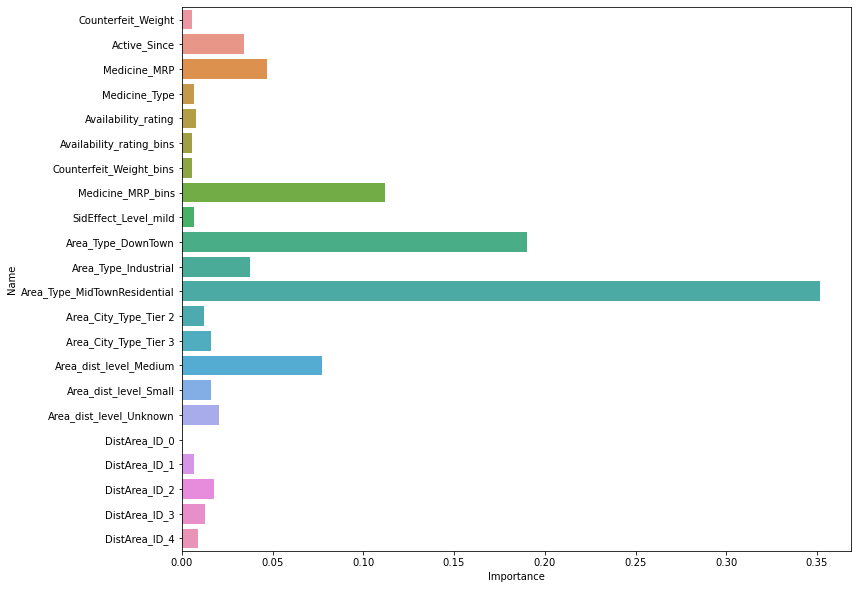

In [1490]:
feat_imp=pd.DataFrame(list(zip(train_d.columns, xgb_rs_best.feature_importances_)), columns=['Name', 'Importance'])

plt.figure(figsize= (12,10))
sns.barplot(y=feat_imp['Name'], x=feat_imp['Importance'])

feat_imp.sort_values('Importance')

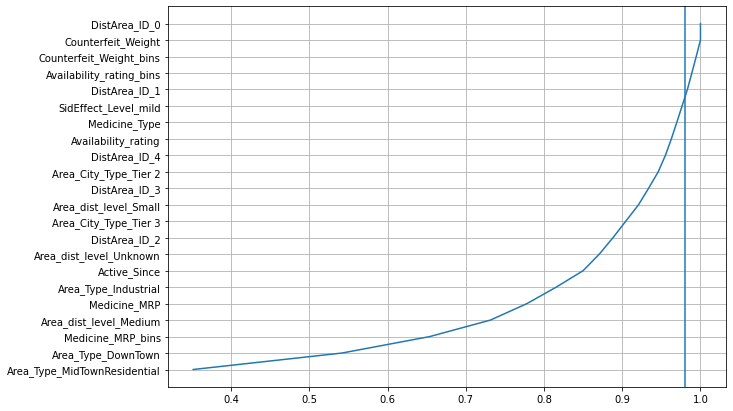

In [1533]:
feat_imp.sort_values('Importance', ascending=False, inplace=True)
importances = feat_imp['Importance']
featuress   = feat_imp['Name']

cum_importance = np.cumsum(importances)
plt.figure(figsize=(10,7))
plt.plot(cum_importance, featuress)
plt.grid()
dashed_line_point  = max(cum_importance)*0.98
plt.axvline(dashed_line_point)

In [1617]:
##Dropping these two variables gave better result, hence we have dropped it earlier while preparing test train
#all_data.drop(['Counterfeit_Weight', 'Availability_rating_bins'] ,axis=1, inplace=True)

Implementing PCA

In [53]:
##PCA
from sklearn.decomposition import PCA
all_data[all_data['data'] =='train'].shape

(6748, 22)

In [54]:
all_data_pca = all_data[all_data['data'] =='train'].copy()
del all_data_pca['data']
pca_data = all_data_pca.values

pca=PCA(n_components=21)
pca.fit(pca_data)

var=pca.explained_variance_ratio_
var1=np.cumsum(pca.explained_variance_ratio_*100)
print(var1)

[ 99.99528737  99.99639386  99.99708923  99.99766414  99.99812571
  99.99851587  99.99881432  99.99909611  99.99936213  99.99955847
  99.99971884  99.99984846  99.9999193   99.99996814  99.99999341
 100.         100.         100.         100.         100.
 100.        ]


In [55]:
target=all_data_pca['Counterfeit_Sales']
pca = PCA(n_components=2)
pca.fit(pca_data)

train_d, test_d, train_dd, test_dd = train_test_split(pca_data , target , test_size = 0.2)

In [1635]:
rfr_best = random_search_forest.best_estimator_
rfr_best.fit(train_d, train_dd)            
predicted_val_rf = rfr_best.predict(test_d)

predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
test_dd_ipca       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))

MAE_rf = mean_absolute_error(test_dd_ipca, predicted_val_rf)
print('Mean absolute error : {0}'.format(MAE_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean absolute error : 273.93647177071404


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished


In [56]:
xgb_rs_best = xgb_rs.best_estimator_
xgb_rs_best.fit(train_d, train_dd)

predicted_val = xgb_rs_best.predict(test_d)
predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))

test_dd_ipca  = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))

MAE = mean_absolute_error(test_dd_ipca, predicted_val)

#Calculating Score
print('Mean absolute error : {0}'.format(MAE))

Mean absolute error : 78.9101689498698


In [61]:
xgb_rs_best.fit(x_train, y_train) 
prd_val=xgb_rs_best.predict(x_test)
prd_val = trgt_scale.inverse_transform(np.array(prd_val).reshape(-1,1))

pd.DataFrame(prd_val).to_csv("D:\Rishabh\Python\P3 Data\Rishabh_Singh_P3_part2.csv", index=False, header=False)